# Metagenomic Read Classification

This notebook shows how to predict the taxonomy of metagenomic reads with neural networks. They work
as follows:

- The input of the models, `x`, is a sequence of symbols comprised within the set `{A, C, G, T}`.
  The input is provided to the models as a one-hot encoded vector or a sequence of tokens, depending
  on the architecture.
- The target of the models, `y`, is an integer indicating a class. The models output a logit vector
  and the class is predicted as the index containing the maximum value.

This notebook uses two datasets to train models with different types of data.

# 1. Short Sequence (1500 nt) Non-Original Dataset: BERTax

This section uses data curated by BERTax (https://www.pnas.org/doi/10.1073/pnas.2122636119)
to facilitate comparison with other metagenomic classification tools. You have to download the
following datasets from https://osf.io/qg6mv/:

- `pretraining_dataset.zip`: used to pretrain NLP-based models.
- `final_model_dataset.zip`: training and evaluation dataset for all models.

In [1]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which the "final" BERTax dataset is to be installed.
BERTAX_FINAL_DIRECTORY = DATA_DIRECTORY + "bertax/final/"

# Directory in which the "pretraining" BERTax dataset is to be installed.
BERTAX_PRETRAINING_DIRECTORY = DATA_DIRECTORY + "bertax/pretraining/"

# Number of samples in each taxon in the test set. We use exactly the same number of samples for
# each genus that BERTax uses.
BERTAX_N_TEST_READ_PER_TAXON = 2000

# BERTax filters out genera with less than 10_000 samples, which yields 155 genera. We exclude reads
# comprising indeterminate nucleotides (i.e. "N") whereas BERTax includes them and we exclude reads
# whose taxonomy cannot be resolved from the NCBI taxonomy database. Thus, we end up with slightly
# less samples than BERTax. Therefore, we filter out genera with less than 9836 samples instead of
# 10000. This results in the exact same 155 genera. We always include 2000 samples per taxon, so
# our test set has the same composition as BERTax, but our training set is slightly smaller than the
# one BERTax uses.
GENUS_MINIMUM_N_READS_PER_TAXON = 9_836

# This parameter avoids unbalancing the dataset by capping the number of samples for each class to
# this value. If we don't cap them, the "other" class (i.e. samples not belonging to the 155
# retained genera) is significantly bigger. This DOES NOT affect the composition of the test set;
# the test set is balanced exactly like in the BERTax paper.
MAX_NUMBER_OF_READS_PER_CLASS = 100_000

# Length of all samples in all BERTax datasets.
BERTAX_READ_LENGTH = 1500

# Filepaths inside of the BERTax directories.
BERTAX_DATASET_DIRECTORY = BERTAX_FINAL_DIRECTORY + "final_model_data_seperate_fasta_per_superkingdom/data/fass2/projects/fk_read_classification/dna_sequences/fragments/genomic_fragments_80_big/"
BERTAX_DOMAINS = (
    "Archaea_db.fa",
    "Bacteria_db.fa",
    "Eukaryota_db.fa",
    "Viruses_db.fa",
)

# Directories to store processed data.
BERTAX_VERSION_1 = BERTAX_FINAL_DIRECTORY + "version1/"
BERTAX_PHYLUM = BERTAX_VERSION_1 + "phylum/"
BERTAX_GENUS = BERTAX_VERSION_1 + "genus/"
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
PROCESSED_PRETRAINING_DATA = BERTAX_PRETRAINING_DIRECTORY + "processed/"
BERTAX_STATISTIC_DIRECTORY = BERTAX_VERSION_1 + "statistics/"
TRAINED_MODELS = "trained_models/"
BERTAX_MODELS = TRAINED_MODELS + "bertax_comparison/"

Defining values to parametrize the rest of the section.


In [ ]:
print("Importing modules and defining utility functions.")
import os
import json
import random
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import numpy as np
import torch
from stelaro.data import (
    ncbi,
    format,
    get_mappings,
)
from stelaro import models


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)

Importing modules and defining utility functions.


In [3]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(NCBI_TAXONOMY_DIRECTORY)
mkdir(PROCESSED_PRETRAINING_DATA)
mkdir(BERTAX_VERSION_1)
mkdir(BERTAX_STATISTIC_DIRECTORY)
mkdir(BERTAX_PHYLUM)
mkdir(BERTAX_GENUS)
mkdir(TRAINED_MODELS)
mkdir(BERTAX_MODELS)

Configuring the environment.


## 1.1. Obtain Data

In [ ]:
ncbi.install_taxonomy(NCBI_TAXONOMY_DIRECTORY)

In [ ]:
tax_ids = set()
n_reads = 0
for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                tax_ids.add(tax_id)
                n_reads += 1
print(f"Out of {n_reads} reads, found {len(tax_ids)} taxonomic identifiers.")
parents, ranks = ncbi.get_all_taxonomy_parents(
    NCBI_TAXONOMY_DIRECTORY + "nodes.dmp",
    NCBI_TAXONOMY_DIRECTORY + "merged.dmp",
)
print("Retrieving names from taxonomic identifiers.")
names = ncbi.taxid_to_names(NCBI_TAXONOMY_DIRECTORY + "names.dmp", set(parents.keys()))
print(f"Found {len(names)} in total.")
print("Resolving the taxonomy.")
lineages = ncbi.resolve_taxonomy(parents, ranks, tax_ids, names)

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.
Out of 5399920 reads, found 5837 taxonomic identifiers.
Retrieving names from taxonomic identifiers.
Found 2677441 in total.
Resolving the taxonomy.
Taxon 621376 is nameless.
Taxon 11232 is nameless.
Taxon 55096 is nameless.
Taxon 2202142 is nameless.
Taxon 45223 is nameless.
Taxon 1740163 is nameless.
Taxon 66266 is nameless.
Taxon 319236 is nameless.
Taxon 640511 is nameless.
Taxon 45219 is nameless.
Taxon 559189 is nameless.
Taxon 1980463 is nameless.
Taxon 207246 is nameless.
Taxon 1980481 is nameless.
Taxon 303300 is nameless.
Taxon 1204252 is nameless.
Taxon 11191 is nameless.
Taxon 1385592 is nameless.
Taxon 1980489 is nameless.
Taxon 237610 is nameless.
Taxon 335659 is nameless.
Taxon 11631 is nameless.
Taxon 1980486 is nameless.
Taxon 49891 is nameless.
Taxon 740710 is nameless.
Taxon 68570 is nameless.
Taxon 11628 is nameless.
Taxon 1980521 is nameles

In [ ]:
taxa = get_mappings(tax_ids, (0, 1, 5), lineages)
print(f"Grouped taxonomic identifiers into {len(taxa)} taxa.")

Mapped 5423 / 5837 taxonomic identifiers.
Grouped taxonomic identifiers into 1908 taxa.


In [ ]:
counts = {key: 0 for key in taxa}
lookup_table = {}
for taxon, identifiers in taxa.items():
    for identifier in identifiers:
        if identifier in lookup_table:
            raise RuntimeError(f"`{identifier} duplicated.")
        lookup_table[identifier] = taxon

for domain in BERTAX_DOMAINS:
    print(f"Inspecting file {domain}.")
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        current_taxon = None
        for line in f:
            if line.startswith(">"):
                tax_id = line.strip()
                tax_id = tax_id.replace(">", "")
                tax_id = tax_id.split(" ")[0]
                if tax_id in lookup_table:
                    taxon = lookup_table[tax_id]
                    counts[taxon] += 1

Inspecting file Archaea_db.fa.
Inspecting file Bacteria_db.fa.
Inspecting file Eukaryota_db.fa.
Inspecting file Viruses_db.fa.


In [ ]:
groupings = []
for level in range(len(list(counts.keys())[0])):
    grouping = {}
    for taxon, read_count in counts.items():
        taxon_level = taxon[:level + 1]
        if taxon_level in grouping:
            grouping[taxon_level] += read_count
        else:
            grouping[taxon_level] = read_count
    groupings.append(grouping)

In [ ]:
def select_groups(grouping, cutoff) -> dict:
    selected_grouping = {("unknown", ): 0}
    for taxon, read_count in grouping.items():
        if read_count >= cutoff:
            selected_grouping[taxon] = read_count
        else:
            selected_grouping[("unknown", )] += read_count
    return selected_grouping


domain_grouping = select_groups(groupings[0], 0)
phylum_grouping = select_groups(groupings[1], 15_000)
genus_grouping = select_groups(groupings[2], GENUS_MINIMUM_N_READS_PER_TAXON)

In [ ]:
def write_indices(grouping, level, dst) -> None:
    index = {}
    for taxon in sorted(grouping):
        index[len(index)] = list(taxon)
    with open(dst + level + "_indices.json", "w") as file:
        json.dump(index, file, indent=4)
    counts = {}
    for taxon in sorted(grouping):
        counts[str(taxon)] = grouping[taxon]
    with open(dst + level + "_counts.json", "w") as file:
        json.dump(counts, file, indent=4)

write_indices(domain_grouping, "domain", BERTAX_STATISTIC_DIRECTORY)
write_indices(genus_grouping, "genus", BERTAX_STATISTIC_DIRECTORY)

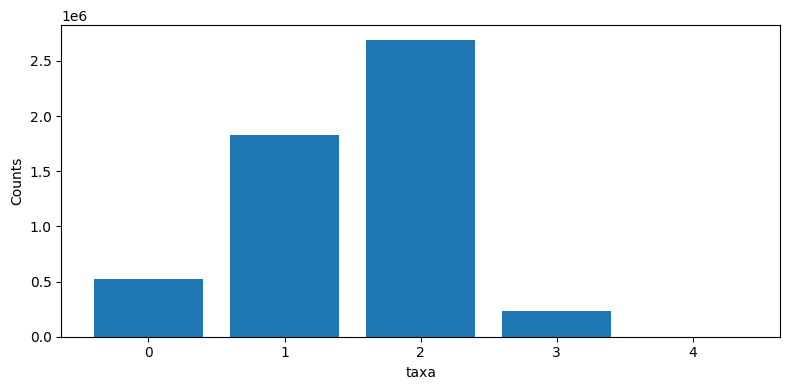

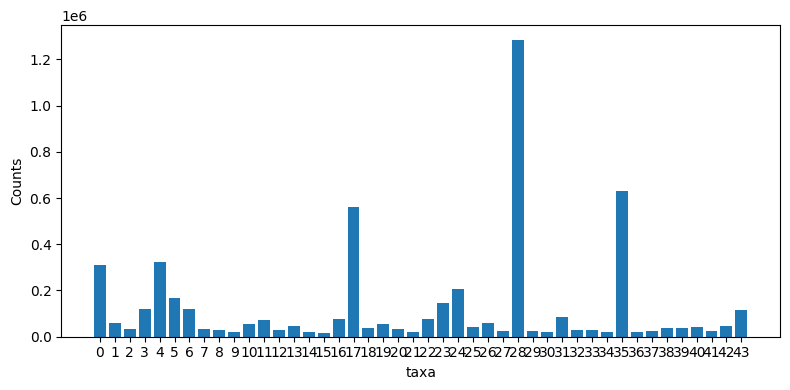

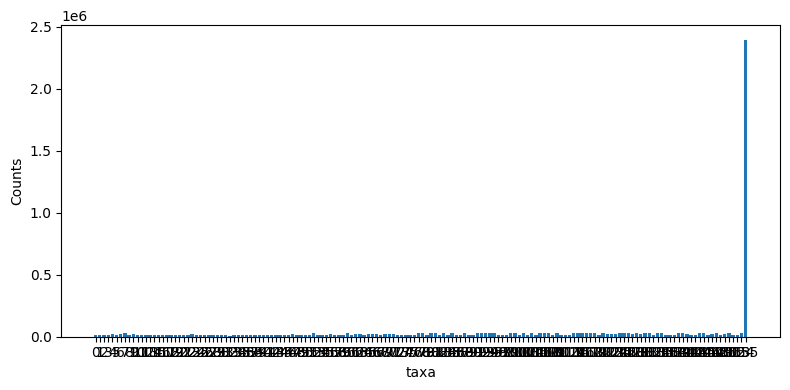

In [ ]:
import matplotlib.pyplot as plt

def plot_dict_bar(data: dict):
    counts = {}
    index = 0
    for taxon in sorted(data):
        counts[str(index)] = data[taxon]
        index += 1
    keys = list(counts.keys())
    counts = list(counts.values())
    plt.figure(figsize=(8, 4))
    plt.bar(keys, counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(domain_grouping)
plot_dict_bar(phylum_grouping)
plot_dict_bar(genus_grouping)


In [ ]:
random.seed(7)


def prepare_datasets(
        mapping: dict,
        n_test: int,
        n_max_training: int,
        validation_fraction: float,
        dst: str
        ) -> tuple:
    """Split read IDs into test, train, and validation sets.

    Args:
        mapping: Map an index to a taxonomy.
        n_test: Number of reads for each taxon in the test set.
        validation_fraction: Fraction of non-test data used for validation.
        dst: Save directory.
    """
    taxon_to_read_IDs = {k: [] for k in mapping}
    reversed_mapping = {tuple(v): k for k, v in mapping.items()}
    granularity = len(mapping["0"])
    # Count reads in each taxon.
    i = 0
    for domain in BERTAX_DOMAINS:
        print(f"Inspecting `{domain}`.")
        with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
            current_ID = None
            for line in tqdm(f):
                if line.startswith(">"):
                    tax_id = line.strip()
                    tax_id = tax_id.replace(">", "")
                    tax_id = tax_id.split(" ")[0]
                    if tax_id in lookup_table:
                        current_taxon = lookup_table[tax_id][:granularity]
                        if current_taxon in reversed_mapping:
                            current_ID = reversed_mapping[current_taxon]
                        else:
                            current_ID = reversed_mapping[("unknown", )]
                elif current_ID:
                    sequence = line.strip().upper()
                    characters = set(sequence)
                    if len(characters) == 4:
                        taxon_to_read_IDs[current_ID].append(i)
                        i += 1
    # Split reads into distinct sets.
    train = {k: [] for k in mapping}
    validation = {k: [] for k in mapping}
    test = {k: [] for k in mapping}
    for taxon in taxon_to_read_IDs:
        random.shuffle(taxon_to_read_IDs[taxon])
        test[taxon] = taxon_to_read_IDs[taxon][:n_test]
        if len(taxon_to_read_IDs[taxon]) > n_max_training:
            train_data = taxon_to_read_IDs[taxon][n_test:n_test + n_max_training]
        else:
            train_data = taxon_to_read_IDs[taxon][n_test:]
        cutoff = int(len(train_data) * validation_fraction)
        train[taxon] = train_data[cutoff:]
        validation[taxon] = train_data[:cutoff]
    # Generate data.
    for name, data in zip(("test", "train", "validate"), (test, train, validation)):
        print(f"{name} set.")
        elements = set()
        for indices in data.values():
            elements.update(indices)
        N = sum([len(v) for v in data.values()])
        with tqdm(total=N) as progress_bar:
            assert N == len(elements), "Unexpected counts."
            x = np.zeros((N, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
            y = np.zeros(N, dtype=np.uint16)
            i = 0
            local_i = 0
            for domain in BERTAX_DOMAINS:
                with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
                    current_ID = None
                    for line in tqdm(f):
                        if line.startswith(">"):
                            tax_id = line.strip()
                            tax_id = tax_id.replace(">", "")
                            tax_id = tax_id.split(" ")[0]
                            if tax_id in lookup_table:
                                current_taxon = lookup_table[tax_id][:granularity]
                                if current_taxon in reversed_mapping:
                                    current_ID = reversed_mapping[current_taxon]
                                else:
                                    current_ID = reversed_mapping[("unknown", )]
                        elif current_ID:
                            sequence = line.strip().upper()
                            characters = set(sequence)
                            if len(characters) == 4:
                                if i in elements:
                                    encoding = format.encode_tetramer(sequence)
                                    x[local_i] = encoding
                                    y[local_i] = int(current_ID)
                                    local_i += 1
                                    elements.remove(i)
                                i += 1
                                progress_bar.update(1)
            assert local_i == N
            mkdir(dst + name)
            np.save(dst + name + "/x.npy", x)
            np.save(dst + name + "/y.npy", y)


with open(BERTAX_STATISTIC_DIRECTORY + "genus_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, MAX_NUMBER_OF_READS_PER_CLASS, 0.05, BERTAX_GENUS)

Inspecting `Archaea_db.fa`.


1070306it [00:39, 26955.97it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:18, 27516.03it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:08, 28669.24it/s]


Inspecting `Viruses_db.fa`.


507606it [00:16, 30102.51it/s]


test set.


1070306it [00:41, 25682.54it/s]                           
3806366it [02:27, 25870.61it/s]
5415562it [03:52, 23243.38it/s]
507606it [00:17, 28369.69it/s]]
5388074it [07:20, 12235.38it/s]


train set.


1070306it [01:18, 13693.18it/s] [01:18<04:57, 6818.37it/s]
3806366it [07:56, 7990.45it/s]20 [09:14<1:21:47, 25.95it/s] 
5415562it [1:05:24, 1379.83it/s]                               
507606it [00:21, 23516.19it/s]/s]
5388074it [1:15:11, 1194.36it/s] 


validate set.


1070306it [00:47, 22683.73it/s]                           
3806366it [02:26, 25900.03it/s]
5415562it [03:45, 24026.71it/s]
507606it [00:19, 26680.85it/s]]
5388074it [07:19, 12268.94it/s]


In [ ]:
with open(BERTAX_STATISTIC_DIRECTORY + "phylum_indices.json") as file:
    mapping = json.load(file)
prepare_datasets(mapping, BERTAX_N_TEST_READ_PER_TAXON, 2_000_000, 0.05, BERTAX_PHYLUM)

Inspecting `Archaea_db.fa`.


1070306it [00:38, 27746.08it/s]


Inspecting `Bacteria_db.fa`.


3806366it [02:11, 28852.29it/s]


Inspecting `Eukaryota_db.fa`.


5415562it [03:09, 28634.58it/s]


Inspecting `Viruses_db.fa`.


507606it [00:17, 28251.23it/s]


test set.


1070306it [00:39, 26964.38it/s]                         
3806366it [02:22, 26773.29it/s]
5415562it [03:21, 26848.14it/s]
507606it [00:24, 20820.36it/s]]
5388074it [06:48, 13196.87it/s]


train set.


1070306it [02:21, 7584.19it/s]3 [02:21<22:16, 3366.06it/s]
3806366it [08:06, 7830.93it/s]93 [10:27<11:51, 3652.13it/s]
5415562it [11:52, 7599.03it/s]                             
507606it [01:04, 7863.72it/s]]
5388074it [23:40, 3794.00it/s]


validate set.


1070306it [00:45, 23477.21it/s]                           
3806366it [02:32, 24997.29it/s]
5415562it [03:40, 24595.01it/s]
507606it [00:22, 22477.95it/s]]
5388074it [07:21, 12204.70it/s]


In [ ]:
total = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if line.startswith(">"):
                total += 1
    print(f"Domain: {domain}. Total: {total}")

x = np.zeros((total, BERTAX_READ_LENGTH // 4), dtype=np.uint8)
i = 0
for domain in BERTAX_DOMAINS:
    with open(BERTAX_DATASET_DIRECTORY + domain, "r") as f:
        for line in f:
            if not line.startswith(">"):
                sequence = line.strip().upper()
                characters = set(sequence)
                if len(characters) == 4:
                    encoding = format.encode_tetramer(sequence)
                    x[i] = encoding
                    i += 1
np.save(PROCESSED_PRETRAINING_DATA + "/x.npy", x)

## 1.2. Validate Data

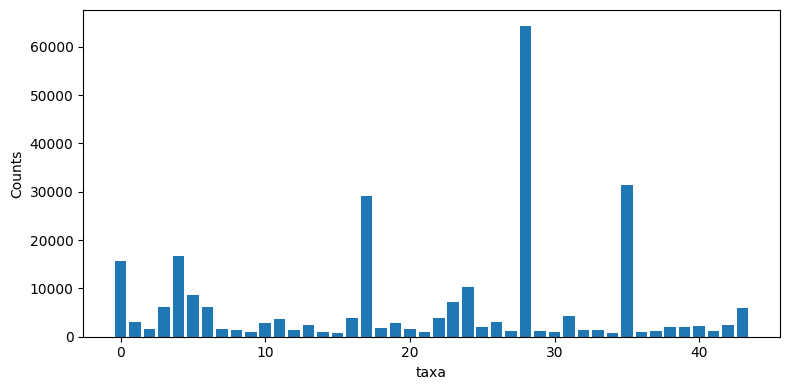

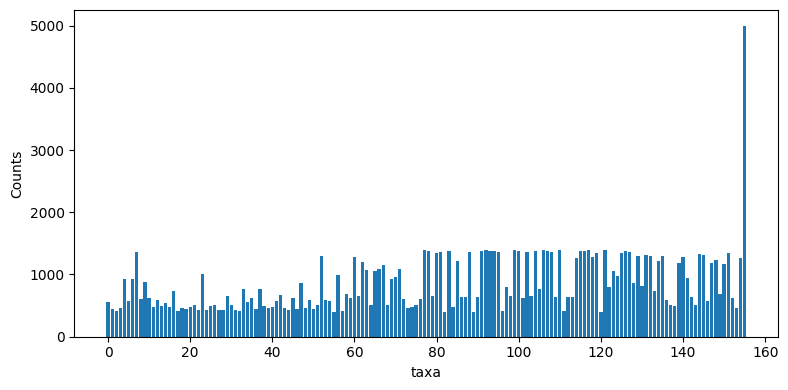

In [ ]:
def plot_dict_bar(path: dict):
    y = np.load(path + "validate/y.npy")
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.xlabel("taxa")
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()


plot_dict_bar(BERTAX_PHYLUM)
plot_dict_bar(BERTAX_GENUS)

Retained genera:

```
{
    "0": [
        "Archaea",
        "Methanobacteriota",
        "Archaeoglobus"
    ],
    "1": [
        "Archaea",
        "Methanobacteriota",
        "Methanobacterium"
    ],
    "2": [
        "Archaea",
        "Methanobacteriota",
        "Methanobrevibacter"
    ],
    "3": [
        "Archaea",
        "Methanobacteriota",
        "Methanocaldococcus"
    ],
    "4": [
        "Archaea",
        "Methanobacteriota",
        "Methanocella"
    ],
    "5": [
        "Archaea",
        "Methanobacteriota",
        "Methanopyrus"
    ],
    "6": [
        "Archaea",
        "Methanobacteriota",
        "Methanosarcina"
    ],
    "7": [
        "Archaea",
        "Methanobacteriota",
        "Thermococcus"
    ],
    "8": [
        "Archaea",
        "Nitrososphaerota",
        "Candidatus Nitrosocaldus"
    ],
    "9": [
        "Archaea",
        "Nitrososphaerota",
        "Nitrosopumilus"
    ],
    "10": [
        "Archaea",
        "Nitrososphaerota",
        "Nitrososphaera"
    ],
    "11": [
        "Archaea",
        "Thermoproteota",
        "Acidilobus"
    ],
    "12": [
        "Archaea",
        "Thermoproteota",
        "Fervidicoccus"
    ],
    "13": [
        "Archaea",
        "Thermoproteota",
        "Pyrobaculum"
    ],
    "14": [
        "Bacteria",
        "Actinomycetota",
        "Actinomyces"
    ],
    "15": [
        "Bacteria",
        "Actinomycetota",
        "Actinopolyspora"
    ],
    "16": [
        "Bacteria",
        "Actinomycetota",
        "Bifidobacterium"
    ],
    "17": [
        "Bacteria",
        "Actinomycetota",
        "Candidatus Planktophila"
    ],
    "18": [
        "Bacteria",
        "Actinomycetota",
        "Egibacter"
    ],
    "19": [
        "Bacteria",
        "Actinomycetota",
        "Egicoccus"
    ],
    "20": [
        "Bacteria",
        "Actinomycetota",
        "Euzebya"
    ],
    "21": [
        "Bacteria",
        "Actinomycetota",
        "Modestobacter"
    ],
    "22": [
        "Bacteria",
        "Actinomycetota",
        "Rubrobacter"
    ],
    "23": [
        "Bacteria",
        "Actinomycetota",
        "Streptomyces"
    ],
    "24": [
        "Bacteria",
        "Bacillota",
        "Limnochorda"
    ],
    "25": [
        "Bacteria",
        "Bdellovibrionota",
        "Bdellovibrio"
    ],
    "26": [
        "Bacteria",
        "Chlamydiota",
        "Chlamydia"
    ],
    "27": [
        "Bacteria",
        "Chlorobiota",
        "Prosthecochloris"
    ],
    "28": [
        "Bacteria",
        "Chloroflexota",
        "Candidatus Promineifilum"
    ],
    "29": [
        "Bacteria",
        "Chloroflexota",
        "Ktedonosporobacter"
    ],
    "30": [
        "Bacteria",
        "Chloroflexota",
        "Roseiflexus"
    ],
    "31": [
        "Bacteria",
        "Cyanobacteriota",
        "Stanieria"
    ],
    "32": [
        "Bacteria",
        "Cyanobacteriota",
        "Synechococcus"
    ],
    "33": [
        "Bacteria",
        "Deinococcota",
        "Deinococcus"
    ],
    "34": [
        "Bacteria",
        "Deinococcota",
        "Thermus"
    ],
    "35": [
        "Bacteria",
        "Nitrospirota",
        "Nitrospira"
    ],
    "36": [
        "Bacteria",
        "Planctomycetota",
        "Candidatus Kuenenia"
    ],
    "37": [
        "Bacteria",
        "Planctomycetota",
        "Gemmata"
    ],
    "38": [
        "Bacteria",
        "Planctomycetota",
        "Sedimentisphaera"
    ],
    "39": [
        "Bacteria",
        "Planctomycetota",
        "Thermogutta"
    ],
    "40": [
        "Bacteria",
        "Pseudomonadota",
        "Acidithiobacillus"
    ],
    "41": [
        "Bacteria",
        "Pseudomonadota",
        "Aeromonas"
    ],
    "42": [
        "Bacteria",
        "Pseudomonadota",
        "Legionella"
    ],
    "43": [
        "Bacteria",
        "Pseudomonadota",
        "Mariprofundus"
    ],
    "44": [
        "Bacteria",
        "Pseudomonadota",
        "Neisseria"
    ],
    "45": [
        "Bacteria",
        "Pseudomonadota",
        "Pseudomonas"
    ],
    "46": [
        "Bacteria",
        "Pseudomonadota",
        "Salinisphaera"
    ],
    "47": [
        "Bacteria",
        "Pseudomonadota",
        "Vibrio"
    ],
    "48": [
        "Bacteria",
        "Spirochaetota",
        "Brachyspira"
    ],
    "49": [
        "Bacteria",
        "Spirochaetota",
        "Leptospira"
    ],
    "50": [
        "Bacteria",
        "Thermodesulfobacteriota",
        "Desulfovibrio"
    ],
    "51": [
        "Bacteria",
        "Verrucomicrobiota",
        "Akkermansia"
    ],
    "52": [
        "Eukaryota",
        "Apicomplexa",
        "Plasmodium"
    ],
    "53": [
        "Eukaryota",
        "Apicomplexa",
        "Theileria"
    ],
    "54": [
        "Eukaryota",
        "Arthropoda",
        "Acyrthosiphon"
    ],
    "55": [
        "Eukaryota",
        "Arthropoda",
        "Apis"
    ],
    "56": [
        "Eukaryota",
        "Arthropoda",
        "Drosophila"
    ],
    "57": [
        "Eukaryota",
        "Arthropoda",
        "Ooceraea"
    ],
    "58": [
        "Eukaryota",
        "Arthropoda",
        "Rhopalosiphum"
    ],
    "59": [
        "Eukaryota",
        "Arthropoda",
        "Spodoptera"
    ],
    "60": [
        "Eukaryota",
        "Arthropoda",
        "Tribolium"
    ],
    "61": [
        "Eukaryota",
        "Arthropoda",
        "Trichoplusia"
    ],
    "62": [
        "Eukaryota",
        "Ascomycota",
        "Aspergillus"
    ],
    "63": [
        "Eukaryota",
        "Ascomycota",
        "Botrytis"
    ],
    "64": [
        "Eukaryota",
        "Ascomycota",
        "Cercospora"
    ],
    "65": [
        "Eukaryota",
        "Ascomycota",
        "Colletotrichum"
    ],
    "66": [
        "Eukaryota",
        "Ascomycota",
        "Fusarium"
    ],
    "67": [
        "Eukaryota",
        "Ascomycota",
        "Pyricularia"
    ],
    "68": [
        "Eukaryota",
        "Ascomycota",
        "Zymoseptoria"
    ],
    "69": [
        "Eukaryota",
        "Bacillariophyta",
        "Phaeodactylum"
    ],
    "70": [
        "Eukaryota",
        "Bacillariophyta",
        "Thalassiosira"
    ],
    "71": [
        "Eukaryota",
        "Basidiomycota",
        "Cryptococcus"
    ],
    "72": [
        "Eukaryota",
        "Basidiomycota",
        "Malassezia"
    ],
    "73": [
        "Eukaryota",
        "Basidiomycota",
        "Mycosarcoma"
    ],
    "74": [
        "Eukaryota",
        "Basidiomycota",
        "Sporisorium"
    ],
    "75": [
        "Eukaryota",
        "Chlorophyta",
        "Ostreococcus"
    ],
    "76": [
        "Eukaryota",
        "Chordata",
        "Anas"
    ],
    "77": [
        "Eukaryota",
        "Chordata",
        "Aquila"
    ],
    "78": [
        "Eukaryota",
        "Chordata",
        "Astyanax"
    ],
    "79": [
        "Eukaryota",
        "Chordata",
        "Aythya"
    ],
    "80": [
        "Eukaryota",
        "Chordata",
        "Betta"
    ],
    "81": [
        "Eukaryota",
        "Chordata",
        "Calypte"
    ],
    "82": [
        "Eukaryota",
        "Chordata",
        "Carassius"
    ],
    "83": [
        "Eukaryota",
        "Chordata",
        "Chanos"
    ],
    "84": [
        "Eukaryota",
        "Chordata",
        "Chrysemys"
    ],
    "85": [
        "Eukaryota",
        "Chordata",
        "Ciona"
    ],
    "86": [
        "Eukaryota",
        "Chordata",
        "Clupea"
    ],
    "87": [
        "Eukaryota",
        "Chordata",
        "Cottoperca"
    ],
    "88": [
        "Eukaryota",
        "Chordata",
        "Cynoglossus"
    ],
    "89": [
        "Eukaryota",
        "Chordata",
        "Danio"
    ],
    "90": [
        "Eukaryota",
        "Chordata",
        "Denticeps"
    ],
    "91": [
        "Eukaryota",
        "Chordata",
        "Echeneis"
    ],
    "92": [
        "Eukaryota",
        "Chordata",
        "Equus"
    ],
    "93": [
        "Eukaryota",
        "Chordata",
        "Erpetoichthys"
    ],
    "94": [
        "Eukaryota",
        "Chordata",
        "Esox"
    ],
    "95": [
        "Eukaryota",
        "Chordata",
        "Gadus"
    ],
    "96": [
        "Eukaryota",
        "Chordata",
        "Gallus"
    ],
    "97": [
        "Eukaryota",
        "Chordata",
        "Gopherus"
    ],
    "98": [
        "Eukaryota",
        "Chordata",
        "Gouania"
    ],
    "99": [
        "Eukaryota",
        "Chordata",
        "Ictalurus"
    ],
    "100": [
        "Eukaryota",
        "Chordata",
        "Lepisosteus"
    ],
    "101": [
        "Eukaryota",
        "Chordata",
        "Microcaecilia"
    ],
    "102": [
        "Eukaryota",
        "Chordata",
        "Monodelphis"
    ],
    "103": [
        "Eukaryota",
        "Chordata",
        "Mus"
    ],
    "104": [
        "Eukaryota",
        "Chordata",
        "Myripristis"
    ],
    "105": [
        "Eukaryota",
        "Chordata",
        "Oncorhynchus"
    ],
    "106": [
        "Eukaryota",
        "Chordata",
        "Ornithorhynchus"
    ],
    "107": [
        "Eukaryota",
        "Chordata",
        "Oryctolagus"
    ],
    "108": [
        "Eukaryota",
        "Chordata",
        "Oryzias"
    ],
    "109": [
        "Eukaryota",
        "Chordata",
        "Perca"
    ],
    "110": [
        "Eukaryota",
        "Chordata",
        "Phyllostomus"
    ],
    "111": [
        "Eukaryota",
        "Chordata",
        "Podarcis"
    ],
    "112": [
        "Eukaryota",
        "Chordata",
        "Rhinatrema"
    ],
    "113": [
        "Eukaryota",
        "Chordata",
        "Salarias"
    ],
    "114": [
        "Eukaryota",
        "Chordata",
        "Sarcophilus"
    ],
    "115": [
        "Eukaryota",
        "Chordata",
        "Scleropages"
    ],
    "116": [
        "Eukaryota",
        "Chordata",
        "Sparus"
    ],
    "117": [
        "Eukaryota",
        "Chordata",
        "Sphaeramia"
    ],
    "118": [
        "Eukaryota",
        "Chordata",
        "Strigops"
    ],
    "119": [
        "Eukaryota",
        "Chordata",
        "Takifugu"
    ],
    "120": [
        "Eukaryota",
        "Chordata",
        "Thamnophis"
    ],
    "121": [
        "Eukaryota",
        "Chordata",
        "Xenopus"
    ],
    "122": [
        "Eukaryota",
        "Chordata",
        "Xiphophorus"
    ],
    "123": [
        "Eukaryota",
        "Euglenozoa",
        "Leishmania"
    ],
    "124": [
        "Eukaryota",
        "Evosea",
        "Dictyostelium"
    ],
    "125": [
        "Eukaryota",
        "Mollusca",
        "Crassostrea"
    ],
    "126": [
        "Eukaryota",
        "Mollusca",
        "Octopus"
    ],
    "127": [
        "Eukaryota",
        "Mollusca",
        "Pomacea"
    ],
    "128": [
        "Eukaryota",
        "Nematoda",
        "Caenorhabditis"
    ],
    "129": [
        "Eukaryota",
        "Platyhelminthes",
        "Schistosoma"
    ],
    "130": [
        "Eukaryota",
        "Rhodophyta",
        "Cyanidioschyzon"
    ],
    "131": [
        "Eukaryota",
        "Streptophyta",
        "Asparagus"
    ],
    "132": [
        "Eukaryota",
        "Streptophyta",
        "Beta"
    ],
    "133": [
        "Eukaryota",
        "Streptophyta",
        "Brassica"
    ],
    "134": [
        "Eukaryota",
        "Streptophyta",
        "Citrus"
    ],
    "135": [
        "Eukaryota",
        "Streptophyta",
        "Coffea"
    ],
    "136": [
        "Eukaryota",
        "Streptophyta",
        "Cucumis"
    ],
    "137": [
        "Eukaryota",
        "Streptophyta",
        "Cucurbita"
    ],
    "138": [
        "Eukaryota",
        "Streptophyta",
        "Cynara"
    ],
    "139": [
        "Eukaryota",
        "Streptophyta",
        "Daucus"
    ],
    "140": [
        "Eukaryota",
        "Streptophyta",
        "Elaeis"
    ],
    "141": [
        "Eukaryota",
        "Streptophyta",
        "Gossypium"
    ],
    "142": [
        "Eukaryota",
        "Streptophyta",
        "Helianthus"
    ],
    "143": [
        "Eukaryota",
        "Streptophyta",
        "Manihot"
    ],
    "144": [
        "Eukaryota",
        "Streptophyta",
        "Musa"
    ],
    "145": [
        "Eukaryota",
        "Streptophyta",
        "Nymphaea"
    ],
    "146": [
        "Eukaryota",
        "Streptophyta",
        "Olea"
    ],
    "147": [
        "Eukaryota",
        "Streptophyta",
        "Papaver"
    ],
    "148": [
        "Eukaryota",
        "Streptophyta",
        "Physcomitrium"
    ],
    "149": [
        "Eukaryota",
        "Streptophyta",
        "Populus"
    ],
    "150": [
        "Eukaryota",
        "Streptophyta",
        "Punica"
    ],
    "151": [
        "Eukaryota",
        "Streptophyta",
        "Quercus"
    ],
    "152": [
        "Eukaryota",
        "Streptophyta",
        "Sesamum"
    ],
    "153": [
        "Eukaryota",
        "Streptophyta",
        "Solanum"
    ],
    "154": [
        "Eukaryota",
        "Streptophyta",
        "Vitis"
    ],
    "155": [
        "unknown"
    ]
}
```

## 1.3. Train Classification Models

### 1.3.1. Load Data

In [ ]:
import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
from torch import nn, exp


def load_data(
        classification_dir: str,
        mapping_filepath: str,
        pretraining_dir: str = None,
        batch_size: int = 128,
        ):
    train_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "train/"),
        batch_size=batch_size,
        shuffle=True
    )
    validation_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "validate/"),
        batch_size=batch_size,
        shuffle=True
    )
    test_data = DataLoader(
        models.SyntheticTetramerDataset(classification_dir + "test/"),
        batch_size=batch_size,
        shuffle=True
    )
    with open(mapping_filepath, "r") as f:
        mapping = json.load(f)
    if pretraining_dir:
        pretraining_data = DataLoader(
            models.SyntheticTetramerDataset(PROCESSED_PRETRAINING_DATA, labels=False),
            batch_size=batch_size,
            shuffle=True
        )
    else:
        pretraining_data = False
    return train_data, validation_data, test_data, mapping, pretraining_data


def sample(data, limit: int, formatter: any) -> tuple:
    x, y = [], []
    i = 0
    for x_batch, y_batch in tqdm(data):
        for xi, yi in zip(x_batch, y_batch):
            x.append(formatter(xi))
            y.append(yi)
            i += 1
            if limit is not None and i >= limit:
                break
        if limit is not None and i >= limit:
            break
    x = np.array(x)
    y = np.array(y)
    _, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(list(range(len(counts))), counts)
    plt.ylabel("Counts")
    plt.tight_layout()
    plt.show()
    assert sum(counts) == limit
    return x, y


def kmer_counts(x: torch.Tensor, K) -> torch.Tensor:
    L = x.shape[0]
    if L < K:
        raise ValueError("Sequence length must be >= k")
    shifts = torch.tensor([6, 4, 2, 0]).view(1, 1, 4)
    x = x.unsqueeze(dim=-1)
    tokens = (x >> shifts) & 0b11
    seq = tokens.view(L * 4)
    num_kmers = 4 ** K
    base = torch.tensor([4**i for i in reversed(range(K))], device=seq.device)
    kmers = torch.stack([seq[i:i + K] for i in range(L - K + 1)], dim=0)
    kmer_ids = (kmers * base).sum(dim=-1)
    counts = torch.zeros(num_kmers, device=seq.device, dtype=torch.float32)
    counts.scatter_add_(0, kmer_ids, torch.ones_like(kmer_ids, dtype=torch.float32))
    counts = counts / counts.sum()
    return counts


train_data, validation_data, test_data, mapping, pretraining_data = load_data(
    BERTAX_GENUS,
    BERTAX_STATISTIC_DIRECTORY + "genus_indices.json",
    BERTAX_PRETRAINING_DIRECTORY,
    128
)

### 1.3.2. Test Models

#### 1.3.2.1. Mamba From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}mamba/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, 180, 200):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Visualization

In [ ]:
training_losses = [
    971.0394643038511, 701.4202324569226, 613.4808391481638, 567.3867947995662,
    531.636268106103, 512.5324469938874, 496.1303058832884, 483.55724356770514,
    463.92975469976665, 457.87459330111744, 449.98715591579673, 444.67504235208037,
    429.5567613780498, 427.4321305721998, 425.85954838246107, 421.7984016761184,
    408.76023176908495, 408.33622827529905, 408.91424648612735, 406.5792498528957,
    393.1753918200731, 396.6206592187285, 395.73642416596414, 396.00011970698836,
    382.84489458203313, 386.1295469284058, 387.0029825627804, 386.4055265530944,
    374.48735032975674, 378.52869715243577, 377.8100764721632, 380.166094404459
]
validation_losses = [
    775.0539880647933, 646.894761680234, 585.878001025509, 551.8459456562167,
    522.5281490835065, 515.6706951901504, 488.492107238419, 474.3740782452559,
    465.79483529124565, 458.12496130044264, 455.20783040088685, 446.9830075354006,
    439.3999383983941, 434.403957029045, 433.52916823323415, 428.4350416495939,
    421.79005181781133, 427.15184312826733, 415.0608627436062, 419.65670830437114,
    412.99433211068146, 410.53245635309685, 407.3217289878967, 406.8154280027511,
    405.68870400300216, 404.6283894583393, 406.9812476118176, 399.77455127840216,
    402.3456248062209, 399.59179129001205, 394.2922423652479, 398.37923013613005
]
precisions = [
    0.49185779, 0.59436597, 0.61728729, 0.65275407,
    0.67349762, 0.67228765, 0.68844777, 0.68101688,
    0.69962463, 0.70501723, 0.71113126, 0.71757062,
    0.71166463, 0.72201261, 0.71749243, 0.72678224,
    0.73408149, 0.72705614, 0.73439712, 0.7317233,
    0.72990127, 0.73025714, 0.73380184, 0.74239784,
    0.73851481, 0.73766978, 0.73043174, 0.73994891,
    0.74303224, 0.74091637, 0.74393667, 0.74475607
]


STEP = 5000
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.array(list(range(len(training_losses))))
x *= STEP
x += STEP
ax[0].plot(x, training_losses, label="Training", linestyle="-", color="black")
ax[0].plot(x, validation_losses, label="Validation", linestyle="--", color="black")
ax[0].set(xlabel='Step', ylabel='Normalized Loss')
ax[0].set_title("Training and Validation Loss")
ax[0].legend()
x = np.array(list(range(len(precisions))))
x *= STEP
x += STEP
r = 0
ax[1].set(xlabel='Step', ylabel="Precision")
ax[1].set_title("Genus Classification Precision")
ax[1].plot(x, precisions, color="black")
plt.show()

#### 1.3.2.2. Mamba-Global From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}mamba_global/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}/weights_140k_steps.pt2"))
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

100%|██████████| 2438/2438 [01:39<00:00, 24.39it/s]


F1 score: [np.float64(0.793429971440136), np.float64(0.9093751875145212), np.float64(0.7254496523864703)]
Macro precision score: [np.float64(0.780362912355497), np.float64(0.9158349526654499), np.float64(0.7511653009347854)]
Weighted precision score: [np.float64(0.986470238192992), np.float64(0.9523022517373643), np.float64(0.7511653009347856)]


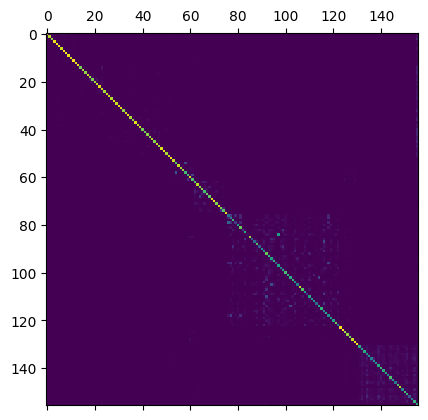

In [9]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.3. Encoder-Only Transformer From Scratch

In [ ]:
directory = f"{BERTAX_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}/weights_80k_steps.pt2"))
optimizer = Adam(classifier.get_parameters(), lr=0.001)
parameters = classifier.get_parameters()
total_params = sum(param.numel() for param in parameters)
print(f"Number of parameters: {total_params:_}")
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (100, 120, 140, 160):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

In [ ]:
training_losses = [
    1104.0754754841328, 885.6949379771947, 824.8031970709562, 795.2423777550459,
    776.1229955524207, 764.661520242691, 754.5584558397532, 747.2260724365711,
    737.6065997511148, 733.7895478785038, 729.3183220982552, 723.8184998452664,
    714.7504637360573, 713.4722261577845, 709.7361436486244, 705.7609434753656,
    699.0237769514322, 696.8162569016218, 695.8526327848434, 692.7705405950546,
    685.8318212002516, 687.7047650009393, 686.1422975599766, 685.5212338417768,
    677.9552626937627, 680.7117942899465, 679.012457165122, 678.7872943371534,
    673.7060093164444, 674.0116150975227, 674.0555215716362, 672.6707854539156,
]
validation_losses = [
    936.9335073081015, 847.0280126354397, 799.8930433621774, 782.8562104514633,
    772.0303439438226, 754.3788229034642, 747.7729960192867, 744.3039972858969,
    736.170336836949, 733.7432061303914, 726.3411262497277, 720.6584439983646,
    717.085791968329, 714.960567943085, 704.8233375965971, 705.5456253631106,
    705.7887134683687, 702.3220030700459, 696.5614498995158, 697.7751316856265,
    691.0935978679096, 693.6498446422711, 687.3844729754531, 690.5160214905654,
    686.3744376567586, 685.0517311516929, 688.6303029213733, 688.7882153978461,
    687.092928836743, 681.0333341535056, 681.5880070612269, 673.9369079325962,
]
precisions = [
    0.37960753, 0.4397967 , 0.469643  , 0.47873073,
    0.48253673, 0.49896063, 0.50816904, 0.49719742,
    0.52486367, 0.5065981 , 0.51539144, 0.51954432,
    0.52510098, 0.52901874, 0.53288903, 0.52876429,
    0.52739711, 0.52976961, 0.53797416, 0.53106656,
    0.54301075, 0.54002066, 0.53780397, 0.53563463,
    0.54234957, 0.53800298, 0.53603231, 0.5482073 ,
    0.53687257, 0.53916082, 0.54254625, 0.54253935,
]


100%|██████████| 2438/2438 [01:50<00:00, 22.08it/s]


F1 score: [np.float64(0.7472959713167822), np.float64(0.7913408347277417), np.float64(0.5239052592187938)]
Macro precision score: [np.float64(0.7347645134933829), np.float64(0.7935540544370511), np.float64(0.5620013453468319)]
Weighted precision score: [np.float64(0.9550254816048159), np.float64(0.8545129043275321), np.float64(0.562001345346832)]


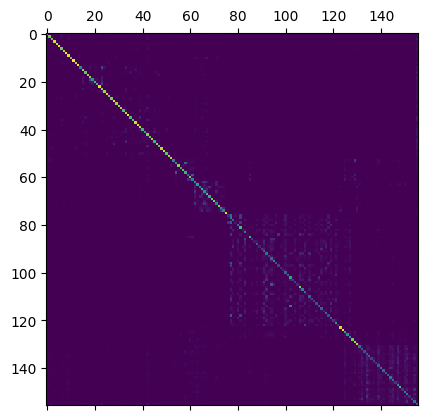

In [8]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.4. Pretrainined Mamba

MLM

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
classifier.model.load_state_dict(load(f"{directory}pretrain_mlm_weights_20k_steps.pt2"))
for total_n_steps in (40, 60, 80, 100):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="mlm"
    )
    print(f"Training losses: {losses_}")
    save(classifier.model.state_dict(), f"{directory}pretrain_mlm_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

Fine-Tuning After 20k Pretraining Steps

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/20k_mlm/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{BERTAX_MODELS}mamba_pretrained/pretrain_mlm_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

In [ ]:
pretraining = [
    5.6952,
    4.9452,
    4.8664,
    4.8436,
    4.8326,
    4.8235,
    4.8175,
    4.8139,
    4.8116,
    4.8063,
    4.8037,
    4.8014,
    4.7992,
    4.7968,
    4.7941,
    4.7930,
    4.7907,
    4.7899,
    4.7898,
    4.7864,
    4.7859,
]
pretraining_entropy = [
    5.3807,
    3.5339,
    3.309,
    3.2666,
    3.2401,
    3.2252,
    3.2117,
    3.2051,
    3.1981,
    3.1889,
    3.1836,
    3.184,
    3.1745,
    3.1732,
    3.1682,
    3.163,
    3.1568,
    3.1542,
    3.1544,
    3.1545,
    3.1501,
]
training_losses = [
    805.5166250914335, 646.3345777094364, 592.3834307134151, 558.5968574434519,
    528.2449533864856, 512.2204388558864, 499.70925740897655, 487.63284566402433,
    467.77320044338705, 462.707614557445, 456.8990695551038, 451.6113565519452,
    435.2197737067938, 435.34225560128687, 431.9859652206302, 428.79390518814324,
]
validation_losses = [
    687.3037584039862, 618.259191762106, 573.0861302805739, 544.130242027952,
    532.8921342875747, 509.9761612353654, 495.3184330874476, 480.52394704459465,
    481.0561708070881, 465.8049739969587, 460.92314308988347, 448.80226249367036,
    449.5481891496168, 443.7575585647555, 436.9725857069522, 433.65018296365935,
]


precisions = [

]

Training losses: [805.5166250914335, 646.3345777094364, 592.3834307134151, 558.5968574434519]
Validation losses: [687.3037584039862, 618.259191762106, 573.0861302805739, 544.130242027952]
Precisions: [array([0.77554743, 0.80997539, 0.82676716, 0.82987149]), array([0.76621158, 0.82785838, 0.8572547 , 0.86461801]), array([0.55215892, 0.60455363, 0.63355068, 0.65198533])]

Training losses: [528.2449533864856, 512.2204388558864, 499.70925740897655, 487.63284566402433]
Validation losses: [532.8921342875747, 509.9761612353654, 495.3184330874476, 480.52394704459465]
Precisions: [array([0.81717642, 0.82627413, 0.84213357, 0.84685956]), array([0.87166745, 0.89145259, 0.88940113, 0.88371019]), array([0.66070773, 0.674352  , 0.68389115, 0.69092355])]

Training losses: [467.77320044338705, 462.707614557445, 456.8990695551038, 451.6113565519452]
Validation losses: [481.0561708070881, 465.8049739969587, 460.92314308988347, 448.80226249367036]
Precisions: [array([0.83755622, 0.83956197, 0.84992174, 0.84249459]), array([0.88344086, 0.89939183, 0.8963435 , 0.90783962]), array([0.69362554, 0.70952163, 0.69873976, 0.71629614])]

Training losses: [435.2197737067938, 435.34225560128687, 431.9859652206302, 428.79390518814324]
Validation losses: [449.5481891496168, 443.7575585647555, 436.9725857069522, 433.65018296365935]
Precisions: [array([0.85082253, 0.8453674 , 0.84854228, 0.85920459]), array([0.89433982, 0.90062254, 0.90602077, 0.9106847 ]), array([0.71057187, 0.71315202, 0.72337538, 0.72255127])]


In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Causal

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
# classifier.model.load_state_dict(load(f"{directory}pretrain_causal_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, ):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="causal"
    )
    print(f"Training losses: {losses_}")
    losses += losses_
    save(classifier.model.state_dict(), f"{directory}pretrain_causal_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

In [ ]:
directory = f"{BERTAX_MODELS}mamba_pretrained/20k_causal/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{BERTAX_MODELS}mamba_pretrained/pretrain_causal_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

In [ ]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.5. Pretrainined Mamba-Global

In [ ]:
directory = f"{BERTAX_MODELS}mamba_global_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
# classifier.model.load_state_dict(load(f"{directory}pretrain_causal_weights_20k_steps.pt2"))
for total_n_steps in (20, 40, ):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="mlm"
    )
    print(f"Training losses: {losses_}")
    losses += losses_
    save(classifier.model.state_dict(), f"{directory}pretrain_mlm_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

In [ ]:
directory = f"{BERTAX_MODELS}mamba_global_pretrained/20k_mlm/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{BERTAX_MODELS}mamba_global_pretrained/pretrain_mlm_weights_20k_steps.pt2"))
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

In [ ]:
from torch import save, load
from stelaro.models import ssm


class C(torch.nn.Module):
    def __init__(
        self,
        N: int,
        num_classes: int,
        vocab_size: int = 256,
        d_model: int = 128,
        n_layers: int = 4,
        d_state: int = 16,
        d_conv: int = 4,
        expand: int = 2,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size + 1, d_model)
        self.layers = nn.ModuleList([
            ssm.MambaBlock(d_model=d_model, d_state=d_state, d_conv=d_conv, expand=expand)
            for _ in range(n_layers)
        ])
        self.norm = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout) if dropout > 0 else nn.Identity()
        self.classifier = nn.Linear(d_model, num_classes)
        self.context_blocks = nn.ModuleList([
            nn.Linear(d_model, d_model) for _ in range(n_layers)
        ])
        self.memory_init = nn.Parameter(torch.zeros(1, d_model))
        self.mlm_head = nn.Linear(d_model, vocab_size + 1)

    def forward(self, x: torch.LongTensor, mlm=None) -> torch.Tensor:
        B = x.size(0)
        h = self.embedding(x)
        memory = self.memory_init.expand(B, -1)

        for i, block in enumerate(self.layers):
            h = block(h)  # each Mamba block returns [B, L, d_model]
            seq_summary = h.mean(dim=1)  # [B, d_model]
            context = self.context_blocks[i](seq_summary)  # [B, d_model]
            h = h + context.unsqueeze(1)
        h = self.norm(h)  # [B, L, d_model]

        if mlm is not None:
            logits = self.mlm_head(h)  # [B, L, vocab_size + 1]
            return logits
        else:
            pooled = h.mean(dim=1)  # [B, d_model]
            pooled = self.dropout(pooled)
            logits = self.classifier(pooled)  # [B, num_classes]
            return logits


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    C(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

#### 1.3.2.6. Pretrained Encoder-Only Transformer

In [ ]:
directory = f"{BERTAX_MODELS}transformer_pretrained/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses = []
for total_n_steps in (20, 40, ):
    losses_ = classifier.pretrain(
        pretraining_data,
        optimizer,
        max_batches=20_000,
        vocab_size=256,
        patience=20,
        probability=0.15,
        evaluation_interval=1000,
        pretraining_type="mlm"
    )
    print(f"Training losses: {losses_}")
    save(classifier.model.state_dict(), f"{directory}pretrain_mlm_weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")

Fine-Tuning after 20k

In [ ]:
directory = f"{BERTAX_MODELS}transformer_pretrained/20k_mlm/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
#classifier.model.load_state_dict(load(f"{BERTAX_MODELS}transformer_pretrained/pretrain_mlm_weights_20k_steps.pt2"))
classifier.model.load_state_dict(load(f"{directory}weights_20k_steps.pt2"))
for total_n_steps in (40, 60, 80, 100, 120, 140, 160, ):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

In [ ]:
pretraining_losses = [
    5.705163955688477, 4.999107947459331, 4.938084951400757, 4.929264972686767, 4.924061805725097,
    4.922049046516419, 4.921978886127472, 4.921536687850952, 4.920234925746918, 4.919230190753937,
    4.919301698207855, 4.916858578681945, 4.916782445907593, 4.915229978561402, 4.915706552028656,
    4.914320007801056, 4.915862394332886, 4.9145742964744565, 4.91518692445755, 4.915528616428375,
    4.912906474590302
]
training_losses = [
    727.8151375830173, 720.0174743324518, 714.8949895441532, 709.3191217213869,
    701.2370649665594, 698.8541110217571, 697.2000942885876, 692.1262321919203,
    687.7396665930748, 686.2131326615811, 685.3708678811788, 684.4469429075718,
    678.6202845275402, 677.3839940160512, 678.488832566142, 677.1490840405226,
    672.8075115859508, 671.2092053890228, 672.7888052344322, 671.7254961848259,
    665.6817490249872, 667.3436414211989, 669.3585550278425, 668.5229763060809,
    663.3070320188999, 664.3852934718132, 666.005477821827, 666.102376627922
]
validation_losses = [
    721.2467398134899, 715.0243972959555, 718.7476185811557, 707.5054048627211,
    709.8039558582138, 700.2802387084047, 693.907730616702, 686.3851939716677,
    690.5321901816338, 690.0568376620149, 687.4633129020102, 689.6204039192013,
    680.2524167780331, 680.1890623674058, 686.9161665968641, 681.3955393276716,
    676.8798117041588, 681.1431255228159, 676.1613420939167, 677.0640907630528,
    677.237026698408, 673.2657355314586, 672.9114417269913, 677.27288551087,
    671.0775988341788, 672.0566022302773, 670.3318000716322, 670.4654034954557
]
precisions = [
    0.77319475,
    0.75024219,
    0.5274218 ,
    0.78693685,
    0.77814201,
    0.54112957,
    0.79259717,
    0.75184636,
    0.53708714,
    0.82672504,
    0.79152554,
    0.55123886,
    0.82757204,
    0.77560824,
    0.5489307 ,
    0.82806388,
    0.76647118,
    0.54537711,
    0.81905055,
    0.79282675,
    0.55790109,
]

100%|██████████| 2438/2438 [01:50<00:00, 22.02it/s]


F1 score: [np.float64(0.7449524460332894), np.float64(0.7976986023898394), np.float64(0.5313229543613616)]
Macro precision score: [np.float64(0.7398697548962616), np.float64(0.803966065089584), np.float64(0.5748419354596472)]
Weighted precision score: [np.float64(0.9572174650091706), np.float64(0.8629408700932304), np.float64(0.5748419354596471)]


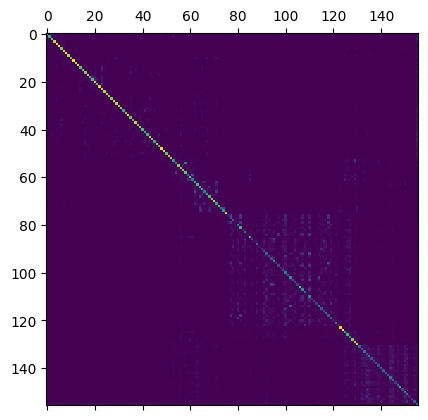

In [8]:
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.7. Mamba from Scratch, 3-mer

In [ ]:
directory = f"{BERTAX_MODELS}mamba_3mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=128,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_codons,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{directory}/weights_20k_steps.pt2"))
for total_n_steps in (40, 60, 80, 100, 120, 140, 160, ):
    print(f"{total_n_steps}k")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

In [ ]:
training_loss = [
    902.35988, 649.98389, 578.59907,
    506.2894079089165, 489.62633293122053, 474.41868062764405, 463.0457775950432,
    445.3890854626894, 439.8190346136689, 433.54437356293204, 429.6375524684787,
    414.5731217622757, 414.613389967382, 411.0214421108365, 408.86170274466275,
    396.1665067881346, 397.34830888062714, 395.4396705418825, 393.8886751458049,
    381.2836233973503, 385.5299224689603, 383.4821105763316, 384.0488971889019,
    372.36278032958506, 374.2326734304428, 375.16971454024315, 374.87004240006206,
    364.4083987310529, 367.52467231303456, 367.4698082864285, 368.11291526556016,
]
validation_loss = [
    703.41407, 611.84963, 558.06458,
    507.9876572100294, 480.56390037139255, 474.21985994708746, 454.29557902177726,
    451.42065958086266, 448.64908571249435, 435.99111732748366, 437.04738555510977,
    430.48467368651654, 417.7668744717238, 416.7532445590385, 411.1271176493597,
    409.21360517627204, 408.487835280251, 407.567458476504, 401.27566053494417,
    401.93196798011377, 395.8183307629014, 397.8800275507047, 394.6106444345787,
    392.4588495134059, 391.4210507023191, 390.51787983148523, 387.7238912842212,
    389.54675322628185, 384.00050018190734, 384.5665174794484, 384.02569145737635,
]
precisions = [
    0.54921, 0.60768, 0.64166,
    0.67889072, 0.68923694, 0.70254976, 0.71125624,
    0.70581577, 0.71436395, 0.71787534, 0.72376451,
    0.7259118 , 0.72778989, 0.72991281, 0.72818333,
    0.73064206, 0.73345709, 0.73948829, 0.74552015,
    0.74239262, 0.74439269, 0.74815724, 0.74890544,
    0.74850754, 0.74886365, 0.74564338, 0.75025501,
    0.75216706, 0.75137265, 0.75960013, 0.74500039,
]

#### 1.3.2.8. CNN-Mamba

In [ ]:
directory = f"{BERTAX_MODELS}cnn_mamba/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
# classifier.model.load_state_dict(load(f"{directory}/weights_20k_steps.pt2"))
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    print(f"{total_n_steps}k")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

In [ ]:
training_losses = [
    830.0691432327033, 603.755170020461, 543.3435241520405, 510.54353565126655,
    478.9559613391757, 465.80077971965073, 454.5848391652107, 443.1669987827539,
    423.7679194226861, 419.130445253849, 416.4550862878561, 411.22283190339806,
    394.795774269104, 394.57711908817294, 392.71155897974967, 390.948001460731,
    376.07097389549017, 377.3288250982761, 376.4499133452773, 376.67107586413624,
    361.5394533634186, 364.8569529935718, 364.61697827875616, 365.7805779531598,
    351.38096238076685, 353.97441851198676, 356.834878090024, 355.77059678435324,
    342.45729445517065, 346.8634478732944, 347.6427922457457, 349.9660012856126
]
validation_losses = [
    652.0647038446098, 565.7686336266618, 518.3381367708749, 499.95742225558456,
    477.3948208281869, 471.88373858952406, 448.02693642600616, 440.1156621552001,
    430.677017754267, 429.4751074203777, 423.6704810934873, 409.2321848132973,
    412.2592415840296, 407.2656867229883, 404.38953954873125, 403.0072720532741,
    395.98471425745265, 400.36553928478014, 395.8179910053214, 389.8736819884668,
    383.7372045905244, 383.21186948790915, 381.6100727713618, 377.40400829167356,
    381.73350142868145, 379.105983010401, 377.61738765719946, 375.1214289355396,
    378.3162864746076, 380.8562792294223, 373.50639425436526, 370.17479128893706
]
precisions = [
    0.57626506, 0.63309339, 0.66051701, 0.68308407,
    0.68801206, 0.70074569, 0.71027766, 0.71544824,
    0.71973226, 0.72668564, 0.73372665, 0.73194424,
    0.73541448, 0.7319659 , 0.7302924 , 0.74129619,
    0.74644318, 0.74620672, 0.74778409, 0.74625766,
    0.74462767, 0.75111971, 0.75334195, 0.75952287,
    0.75754402, 0.75226032, 0.75254285, 0.7552706 ,
    0.75417704, 0.75472242, 0.75768223, 0.76634493,
]

#### 1.3.2.9. Mamba-Memory-CNN

In [ ]:
directory = f"{BERTAX_MODELS}mamba_memory_cnn/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierMemoryCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160, ):
    print(f"{total_n_steps}k")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

#### 1.3.2.10. Random Forest

In [ ]:
K = 6
N_TRAINING_SAMPLES = 100_000
N_TEST_SAMPLE = 20_000


x, y = sample(train_data, N_TRAINING_SAMPLES, lambda x: kmer_counts(x, K))
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    n_jobs=1,
)
rf.fit(x, y)
x_test, y_test = sample(test_data, N_TEST_SAMPLE, lambda x: kmer_counts(x, K))
y_pred = rf.predict(x_test)

mappings = models.obtain_rank_based_mappings(mapping)
result = models.rank_based_precision(mappings, y_test, y_pred)
rounded_result = [float(f"{r:.5}") for r in result[::-1]]
print(f"Macro Precision: {rounded_result}")

matrix = np.zeros((len(mapping), len(mapping)))
for t, p in zip(y_test, y_pred):
    matrix[t][p] += 1
plt.matshow(matrix)
plt.show()

#### 1.3.2.11. Large Transformer

Number of parameters: 3_105_413


 95%|█████████▌| 4655/4875 [05:00<00:14, 15.52it/s]


Halting evaluation after 297984 data points.
F1 score: [np.float64(0.7239903010413486), np.float64(0.7605390720077408), np.float64(0.49014971119787276)]
Macro precision score: [np.float64(0.7284560922169138), np.float64(0.7792670399115383), np.float64(0.5409945979843649)]
Weighted precision score: [np.float64(0.9483962874286628), np.float64(0.8386132904591528), np.float64(0.5412140698522443)]


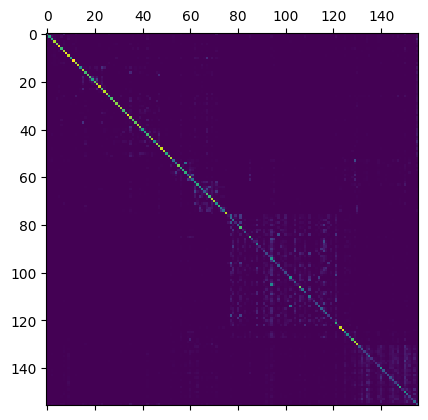

RuntimeError: 

In [4]:
directory = f"{BERTAX_MODELS}transformer_large/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer


classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=200,
        vocab_size=256,
        n_head=4,
        n_layers=6,
        classification_type="token"
    ),
    format.to_tetramers,
    True
)
parameters = classifier.get_parameters()
total_params = sum(param.numel() for param in parameters)
print(f"Number of parameters: {total_params:_}")
# optimizer = Adam(classifier.get_parameters(), lr=0.001)
# losses_ = classifier.pretrain(
#     pretraining_data,
#     optimizer,
#     max_batches=10_000,
#     vocab_size=256,
#     patience=20,
#     probability=0.15,
#     evaluation_interval=200,
#     pretraining_type="mlm"
# )
# print(f"Training losses: {losses_}")
# save(classifier.model.state_dict(), f"{directory}pretrain_weights_10k_steps.pt2")


classifier.model.load_state_dict(load(f"{directory}/weights_3_epoch.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
raise RuntimeError
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for epoch in (2, 3, 4, ):
    print(f"Epoch: {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=500,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=100_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epoch.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

#### 1.3.2.12. Residual Mamba

In [4]:
directory = f"{BERTAX_MODELS}mamba_residual/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierResidual(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
for total_n_steps in (20, 40, 60, 80, 100, 120, 140, 160):
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=2,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5000,
        evaluation_maximum_duration=30.0,
        patience_interval=5000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{total_n_steps}k_steps.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

/mnt/d/maitrise/stelaro/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 25%|██▍       | 5000/20040 [16:06<51:43,  4.85it/s]  

Halting evaluation after 61568 data points.
Halting evaluation after 68352 data points.


 25%|██▍       | 5001/20040 [17:51<131:52:47, 31.57s/it]

Halting evaluation after 68864 data points.
1/2 F1: [0.68494, 0.63839, 0.3886]. Precision: [0.68017, 0.64113, 0.42279] 
Training loss: 1093.96218. Validation loss: 867.56738. Patience: 200


 50%|████▉     | 10000/20040 [9:47:32<29:07,  5.75it/s]       

Halting evaluation after 70656 data points.
Halting evaluation after 71168 data points.


 50%|████▉     | 10001/20040 [9:49:18<88:23:22, 31.70s/it]

Halting evaluation after 69632 data points.
1/2 F1: [0.75725, 0.75611, 0.5005]. Precision: [0.75905, 0.74623, 0.52562] 
Training loss: 780.74532. Validation loss: 709.12149. Patience: 200


 65%|██████▍   | 12951/20040 [9:58:14<5:27:27,  2.77s/it] 


KeyboardInterrupt: 

#### 1.3.2.13. Mamba 2-mer

In [ ]:
directory = f"{BERTAX_MODELS}mamba_2mer/"
mkdir(directory)
from torch import save, load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=16,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_pairs,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{directory}/weights_1_epoch.pt2"))
parameters = classifier.get_parameters()
total_params = sum(param.numel() for param in parameters)
print(f"Number of parameters: {total_params:_}")
for epoch in (2, 3, 4, 5, 6, 7, 8, ):
    print(f"Epoch: {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=500,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=5_000,
        evaluation_maximum_duration=30.0,
        patience_interval=5_000,
        n_max_steps=100_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epoch.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Number of parameters: 491_693
Epoch: 2


  0%|          | 3/20040 [00:15<27:59:02,  5.03s/it]


KeyboardInterrupt: 

### 1.3.3. Visualize Results

#### 1.3.3.1. Mamba from Sratch

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


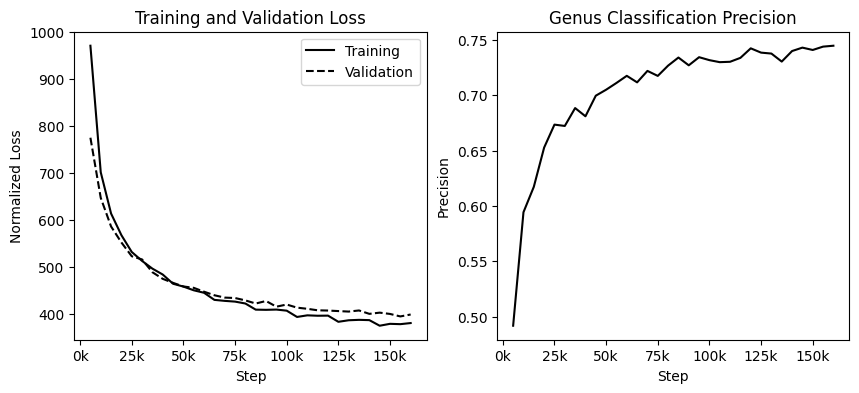

In [43]:
training_losses = [
    971.0394643038511, 701.4202324569226, 613.4808391481638, 567.3867947995662,
    531.636268106103, 512.5324469938874, 496.1303058832884, 483.55724356770514,
    463.92975469976665, 457.87459330111744, 449.98715591579673, 444.67504235208037,
    429.5567613780498, 427.4321305721998, 425.85954838246107, 421.7984016761184,
    408.76023176908495, 408.33622827529905, 408.91424648612735, 406.5792498528957,
    393.1753918200731, 396.6206592187285, 395.73642416596414, 396.00011970698836,
    382.84489458203313, 386.1295469284058, 387.0029825627804, 386.4055265530944,
    374.48735032975674, 378.52869715243577, 377.8100764721632, 380.166094404459
]
validation_losses = [
    775.0539880647933, 646.894761680234, 585.878001025509, 551.8459456562167,
    522.5281490835065, 515.6706951901504, 488.492107238419, 474.3740782452559,
    465.79483529124565, 458.12496130044264, 455.20783040088685, 446.9830075354006,
    439.3999383983941, 434.403957029045, 433.52916823323415, 428.4350416495939,
    421.79005181781133, 427.15184312826733, 415.0608627436062, 419.65670830437114,
    412.99433211068146, 410.53245635309685, 407.3217289878967, 406.8154280027511,
    405.68870400300216, 404.6283894583393, 406.9812476118176, 399.77455127840216,
    402.3456248062209, 399.59179129001205, 394.2922423652479, 398.37923013613005
]
precisions = [
    0.49185779, 0.59436597, 0.61728729, 0.65275407,
    0.67349762, 0.67228765, 0.68844777, 0.68101688,
    0.69962463, 0.70501723, 0.71113126, 0.71757062,
    0.71166463, 0.72201261, 0.71749243, 0.72678224,
    0.73408149, 0.72705614, 0.73439712, 0.7317233,
    0.72990127, 0.73025714, 0.73380184, 0.74239784,
    0.73851481, 0.73766978, 0.73043174, 0.73994891,
    0.74303224, 0.74091637, 0.74393667, 0.74475607
]

STEP = 5000
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.array(list(range(len(training_losses))))
x *= STEP
x += STEP
ax[0].plot(x, training_losses, label="Training", linestyle="-", color="black")
ax[0].plot(x, validation_losses, label="Validation", linestyle="--", color="black")
ax[0].set(xlabel='Step', ylabel='Normalized Loss')
ax[0].set_title("Training and Validation Loss")
ax[0].legend()
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))
x = np.array(list(range(len(precisions))))
x *= STEP
x += STEP
r = 0
ax[1].set(xlabel='Step', ylabel="Precision")
ax[1].set_title("Genus Classification Precision")
ax[1].plot(x, precisions, color="black")
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))
plt.savefig('/mnt/d/maitrise/resultats/mamba.eps')
plt.show()

#### 1.3.3.2. Pretraining

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


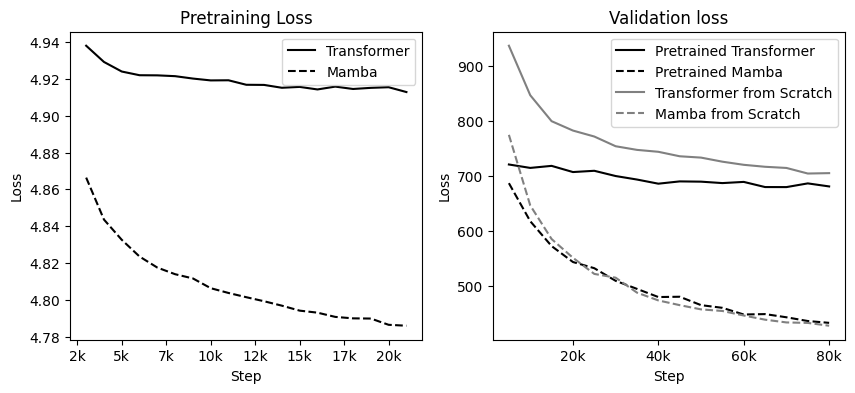

In [44]:
transformer_pretraining_losses = [
    # 5.705163955688477,
    # 4.999107947459331,
    4.938084951400757, 4.929264972686767, 4.924061805725097,
    4.922049046516419, 4.921978886127472, 4.921536687850952, 4.920234925746918, 4.919230190753937,
    4.919301698207855, 4.916858578681945, 4.916782445907593, 4.915229978561402, 4.915706552028656,
    4.914320007801056, 4.915862394332886, 4.9145742964744565, 4.91518692445755, 4.915528616428375,
    4.912906474590302
]
mamba_pretraining_losses = [
    # 5.6952,
    #4.9452,
    4.8664, 4.8436, 4.8326,
    4.8235, 4.8175, 4.8139, 4.8116, 4.8063,
    4.8037, 4.8014, 4.7992, 4.7968, 4.7941,
    4.7930, 4.7907, 4.7899, 4.7898, 4.7864,
    4.7859,
]

PRETRAINING_STEP = 1000
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.array(list(range(len(transformer_pretraining_losses))))
x *= PRETRAINING_STEP
x += PRETRAINING_STEP * 3  # Skipping the first two losses
ax[0].plot(x, transformer_pretraining_losses, label="Transformer", linestyle="-", color="black")
ax[0].plot(x, mamba_pretraining_losses, label="Mamba", linestyle="--", color="black")
ax[0].set(xlabel='Step', ylabel='Loss')
ax[0].set_title("Pretraining Loss")
ax[0].legend()
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))

pretrained_transformer_validation_losses = [
    721.2467398134899, 715.0243972959555, 718.7476185811557, 707.5054048627211,
    709.8039558582138, 700.2802387084047, 693.907730616702, 686.3851939716677,
    690.5321901816338, 690.0568376620149, 687.4633129020102, 689.6204039192013,
    680.2524167780331, 680.1890623674058, 686.9161665968641, 681.3955393276716,
    # 676.8798117041588, 681.1431255228159, 676.1613420939167, 677.0640907630528,
    # 677.237026698408, 673.2657355314586, 672.9114417269913, 677.27288551087,
    # 671.0775988341788, 672.0566022302773, 670.3318000716322, 670.4654034954557
]
pretrained_mamba_validation_losses = [
    687.3037584039862, 618.259191762106, 573.0861302805739, 544.130242027952,
    532.8921342875747, 509.9761612353654, 495.3184330874476, 480.52394704459465,
    481.0561708070881, 465.8049739969587, 460.92314308988347, 448.80226249367036,
    449.5481891496168, 443.7575585647555, 436.9725857069522, 433.65018296365935,
]
transformer_validation_losses = [
    936.9335073081015, 847.0280126354397, 799.8930433621774, 782.8562104514633,
    772.0303439438226, 754.3788229034642, 747.7729960192867, 744.3039972858969,
    736.170336836949, 733.7432061303914, 726.3411262497277, 720.6584439983646,
    717.085791968329, 714.960567943085, 704.8233375965971, 705.5456253631106,
    # 705.7887134683687, 702.3220030700459, 696.5614498995158, 697.7751316856265,
    # 691.0935978679096, 693.6498446422711, 687.3844729754531, 690.5160214905654,
    # 686.3744376567586, 685.0517311516929, 688.6303029213733, 688.7882153978461,
    # 687.092928836743, 681.0333341535056, 681.5880070612269, 673.9369079325962,
]
mamba_validation_losses = [
    775.0539880647933, 646.894761680234, 585.878001025509, 551.8459456562167,
    522.5281490835065, 515.6706951901504, 488.492107238419, 474.3740782452559,
    465.79483529124565, 458.12496130044264, 455.20783040088685, 446.9830075354006,
    439.3999383983941, 434.403957029045, 433.52916823323415, 428.4350416495939,
    # 421.79005181781133, 427.15184312826733, 415.0608627436062, 419.65670830437114,
    # 412.99433211068146, 410.53245635309685, 407.3217289878967, 406.8154280027511,
    # 405.68870400300216, 404.6283894583393, 406.9812476118176, 399.77455127840216,
    # 402.3456248062209, 399.59179129001205, 394.2922423652479, 398.37923013613005
]
STEP = 5000
x = np.array(list(range(len(transformer_validation_losses))))
x *= STEP
x += STEP
r = 0
ax[1].set(xlabel='Step', ylabel="Loss")
ax[1].set_title("Validation loss")
ax[1].plot(x, pretrained_transformer_validation_losses, label="Pretrained Transformer", linestyle="-", color="black")
ax[1].plot(x, pretrained_mamba_validation_losses, label="Pretrained Mamba", linestyle="--", color="black")
ax[1].plot(x, transformer_validation_losses, label="Transformer from Scratch", linestyle="-", color="gray")
ax[1].plot(x, mamba_validation_losses, label="Mamba from Scratch", linestyle="--", color="gray")
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))
ax[1].legend()
plt.savefig('/mnt/d/maitrise/resultats/pretraining.eps')
plt.show()

#### 1.3.3.3. Tokenization

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


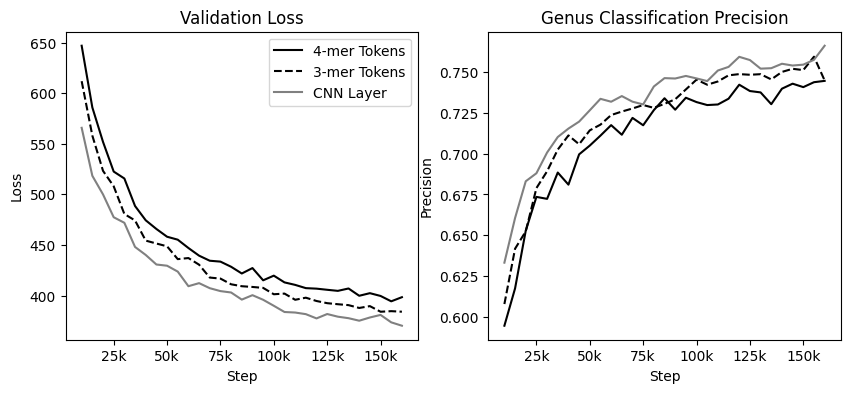

In [45]:
mamba_4_validation_losses = [
    # 775.0539880647933,
    646.894761680234, 585.878001025509, 551.8459456562167,
    522.5281490835065, 515.6706951901504, 488.492107238419, 474.3740782452559,
    465.79483529124565, 458.12496130044264, 455.20783040088685, 446.9830075354006,
    439.3999383983941, 434.403957029045, 433.52916823323415, 428.4350416495939,
    421.79005181781133, 427.15184312826733, 415.0608627436062, 419.65670830437114,
    412.99433211068146, 410.53245635309685, 407.3217289878967, 406.8154280027511,
    405.68870400300216, 404.6283894583393, 406.9812476118176, 399.77455127840216,
    402.3456248062209, 399.59179129001205, 394.2922423652479, 398.37923013613005
]
mamba_4_precisions = [
    # 0.49185779,
    0.59436597, 0.61728729, 0.65275407,
    0.67349762, 0.67228765, 0.68844777, 0.68101688,
    0.69962463, 0.70501723, 0.71113126, 0.71757062,
    0.71166463, 0.72201261, 0.71749243, 0.72678224,
    0.73408149, 0.72705614, 0.73439712, 0.7317233,
    0.72990127, 0.73025714, 0.73380184, 0.74239784,
    0.73851481, 0.73766978, 0.73043174, 0.73994891,
    0.74303224, 0.74091637, 0.74393667, 0.74475607
]
mamba_3_validation_loss = [
    # 703.41407,
    611.84963, 558.06458, 523.23521,
    507.9876572100294, 480.56390037139255, 474.21985994708746, 454.29557902177726,
    451.42065958086266, 448.64908571249435, 435.99111732748366, 437.04738555510977,
    430.48467368651654, 417.7668744717238, 416.7532445590385, 411.1271176493597,
    409.21360517627204, 408.487835280251, 407.567458476504, 401.27566053494417,
    401.93196798011377, 395.8183307629014, 397.8800275507047, 394.6106444345787,
    392.4588495134059, 391.4210507023191, 390.51787983148523, 387.7238912842212,
    389.54675322628185, 384.00050018190734, 384.5665174794484, 384.02569145737635,
]
mamba_3_precisions = [
    # 0.54921,
    0.60768, 0.64166, 0.65233,
    0.67889072, 0.68923694, 0.70254976, 0.71125624,
    0.70581577, 0.71436395, 0.71787534, 0.72376451,
    0.7259118 , 0.72778989, 0.72991281, 0.72818333,
    0.73064206, 0.73345709, 0.73948829, 0.74552015,
    0.74239262, 0.74439269, 0.74815724, 0.74890544,
    0.74850754, 0.74886365, 0.74564338, 0.75025501,
    0.75216706, 0.75137265, 0.75960013, 0.74500039,
]
mamba_cnn_validation_losses = [
    # 652.0647038446098,
    565.7686336266618, 518.3381367708749, 499.95742225558456,
    477.3948208281869, 471.88373858952406, 448.02693642600616, 440.1156621552001,
    430.677017754267, 429.4751074203777, 423.6704810934873, 409.2321848132973,
    412.2592415840296, 407.2656867229883, 404.38953954873125, 403.0072720532741,
    395.98471425745265, 400.36553928478014, 395.8179910053214, 389.8736819884668,
    383.7372045905244, 383.21186948790915, 381.6100727713618, 377.40400829167356,
    381.73350142868145, 379.105983010401, 377.61738765719946, 375.1214289355396,
    378.3162864746076, 380.8562792294223, 373.50639425436526, 370.17479128893706
]
mamba_cnn_precisions = [
    # 0.57626506,
    0.63309339, 0.66051701, 0.68308407,
    0.68801206, 0.70074569, 0.71027766, 0.71544824,
    0.71973226, 0.72668564, 0.73372665, 0.73194424,
    0.73541448, 0.7319659 , 0.7302924 , 0.74129619,
    0.74644318, 0.74620672, 0.74778409, 0.74625766,
    0.74462767, 0.75111971, 0.75334195, 0.75952287,
    0.75754402, 0.75226032, 0.75254285, 0.7552706 ,
    0.75417704, 0.75472242, 0.75768223, 0.76634493,
]

STEP = 5000
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
x = np.array(list(range(len(mamba_4_validation_losses))))
x *= STEP
x += STEP * 2
ax[0].plot(x, mamba_4_validation_losses, label="4-mer Tokens", linestyle="-", color="black")
ax[0].plot(x, mamba_3_validation_loss, label="3-mer Tokens", linestyle="--", color="black")
ax[0].plot(x, mamba_cnn_validation_losses, label="CNN Layer", linestyle="-", color="grey")
ax[0].set(xlabel='Step', ylabel='Loss')
ax[0].set_title("Validation Loss")
ax[0].legend()
ax[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))

x = np.array(list(range(len(mamba_cnn_precisions))))
x *= STEP
x += STEP * 2
r = 0
ax[1].set(xlabel='Step', ylabel="Precision")
ax[1].plot(x, mamba_4_precisions, label="4-mer Tokens", linestyle="-", color="black")
ax[1].plot(x, mamba_3_precisions, label="3-mer Tokens", linestyle="--", color="black")
ax[1].plot(x, mamba_cnn_precisions, label="CNN Layer", linestyle="-", color="grey")
ax[1].set_title("Genus Classification Precision")
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x//1000) + 'k'))
plt.savefig('/mnt/d/maitrise/resultats/tokens.eps')
plt.show()

#### 1.3.3.4. Comparison

Scratch Mamba

100%|██████████| 2438/2438 [01:36<00:00, 25.21it/s]


F1 score: [np.float64(0.7868765600054513), np.float64(0.9070949156054595), np.float64(0.7240705188963996)]
Macro precision score: [np.float64(0.777582148975063), np.float64(0.917876698143862), np.float64(0.7507742957079443)]
Weighted precision score: [np.float64(0.9847969368890989), np.float64(0.9505645509772216), np.float64(0.7507742957079443)]


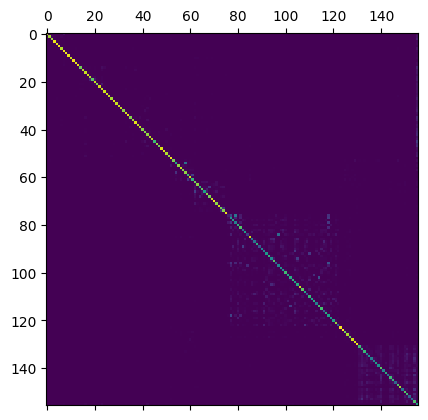

In [46]:
directory = f"{BERTAX_MODELS}mamba/"
mkdir(directory)
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}/weights_160k_steps.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Mamba-CNN

100%|██████████| 2438/2438 [01:49<00:00, 22.28it/s]


F1 score: [np.float64(0.7832038127669296), np.float64(0.9144627752783364), np.float64(0.7407302268382758)]
Macro precision score: [np.float64(0.7767413425120658), np.float64(0.9276289135145086), np.float64(0.7698204826171341)]
Weighted precision score: [np.float64(0.9883788385017387), np.float64(0.9591028102546224), np.float64(0.7698204826171341)]


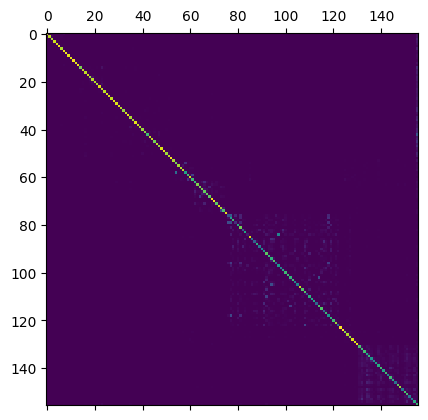

In [ ]:
directory = f"{BERTAX_MODELS}cnn_mamba/"
from torch import load
from stelaro.models import ssm

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
classifier.model.load_state_dict(load(f"{directory}/weights_160k_steps.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

Pretrained Transformer

100%|██████████| 2438/2438 [01:52<00:00, 21.59it/s]


F1 score: [np.float64(0.7449524460332894), np.float64(0.7976986023898394), np.float64(0.5313229543613616)]
Macro precision score: [np.float64(0.7398697548962616), np.float64(0.803966065089584), np.float64(0.5748419354596472)]
Weighted precision score: [np.float64(0.9572174650091706), np.float64(0.8629408700932304), np.float64(0.5748419354596471)]


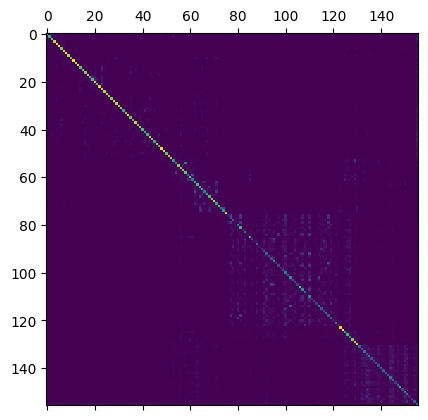

In [40]:
directory = f"{BERTAX_MODELS}transformer_pretrained/"
from torch import load
from stelaro.models import transformer

classifier = models.Classifier(
    BERTAX_READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=BERTAX_READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
classifier.model.load_state_dict(load(f"{directory}20k_mlm/weights_160k_steps.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

# 2. Long Sequence (6000 nt) Original Dataset

This section validates metagenomic classification models with an original synthetic read dataset
generated from RefSeq, an NCBI genome database, and GTDB, a phylogenomic database.

In [1]:
print("Defining values to parametrize the rest of the section.")

# Directory in which all data are to be written.
DATA_DIRECTORY = "../data/"

# Directory in which NCBI files summarizing the composition of RefSeq are to be stored.
SUMMARY_DIRECTORY = DATA_DIRECTORY + "ncbi_genome_summaries/"

# Directories in which taxonomy files are to be installed.
NCBI_TAXONOMY_DIRECTORY = DATA_DIRECTORY + "ncbi_taxonomy/"
TAXONOMY_DIRECTORY = DATA_DIRECTORY + "gtdb/"

# Number of reference genomes for each taxon to classify.
N_REFERENCE_GENOMES_PER_TAXON = 10

# Number of reference genomes for each taxon in the test set.
N_REFERENCE_GENOMES_TEST_SET = 4

# Number of synthetic samples in each taxon of the test set.
N_TEST_READ_PER_TAXON = 1000

# Number of synthetic samples in each taxon of the training set. Balanced, contrarily to BERTax.
N_MAX_TRAINING_READ_PER_TAXON = 4000

# Number of samples in each taxon of the validation set. Balanced, contrarily to BERTax. A smaller
# number of samples is used to accelerate mid-training evaluations.
N_MAX_VALIDATION_READ_PER_TAXON = 500

# Number of samples in each taxon of the pretraining set. Balanced, contrarily to BERTax.
N_MAX_PRETRAINING_READ_PER_TAXON = 1000

# Length of the synthetic reads.
READ_LENGTH = 6000

# Name of the directory containing the original dataset.
LONG_READ_CLASSIFICATION_DIRECTORY = DATA_DIRECTORY + "long_dataset/"

# File containing the list of RefSeq reference genomes used to create synthetic reads.
GENOME_INDEX_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "index.tsv"

# File containing the initial binning of reference genomes.
GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "bin.json"
TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "test_bin.json"
NON_TEST_GENOME_BINNING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test_bin.json"

# File containing a dictionary that maps indices to taxa.
MAPPING_FILE = LONG_READ_CLASSIFICATION_DIRECTORY + "mapping.json"

# Directory to store raw NCBI reference genome data.
RAW_GENOME_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "raw_data/"

# Processed data directories.
TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "test/"
NON_TEST_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "non_test/"
TRAINING_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "train/"
VALIDATION_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "validate/"
PRETRAINING_DIRECTORY = LONG_READ_CLASSIFICATION_DIRECTORY + "pretraining/"

# Directories to store processed data.
TRAINED_MODELS = "trained_models/"
LONG_TRAINED_MODELS = "trained_models/long/"

Defining values to parametrize the rest of the section.


In [2]:
print("Importing modules and defining utility functions.")
import os
import json
import numpy as np
from stelaro.data import (
    ncbi,
    Taxonomy,
    gtdb,
    format,
    synthetic,
    get_urls,
    make_index_file,
)


def mkdir(path: str) -> None:
    """Create a directory if it does not exist."""
    if not os.path.exists(path):
        os.makedirs(path)


def rename(original: str, new: str) -> None:
    os.rename(original, new)

Importing modules and defining utility functions.


In [6]:
print("Configuring the environment.")
mkdir(DATA_DIRECTORY)
mkdir(LONG_READ_CLASSIFICATION_DIRECTORY)
mkdir(TEST_DIRECTORY)
mkdir(TRAINING_DIRECTORY)
mkdir(VALIDATION_DIRECTORY)
mkdir(PRETRAINING_DIRECTORY)
mkdir(TRAINED_MODELS)
mkdir(LONG_TRAINED_MODELS)
mkdir(RAW_GENOME_DIRECTORY)
mkdir(NON_TEST_DIRECTORY)

Configuring the environment.


## 2.1. Prepare Data

### 2.1.1. Download Reference Genomes

In [ ]:
mkdir(SUMMARY_DIRECTORY)
ncbi.install_summaries(SUMMARY_DIRECTORY)
ncbi.summarize_assemblies(SUMMARY_DIRECTORY)

archaea: 2 579 genomes
bacteria: 432 090 genomes
fungi: 644 genomes
invertebrate: 434 genomes
plant: 186 genomes
protozoa: 121 genomes
vertebrate mammalian: 239 genomes
vertebrate other: 432 genomes
viral: 14 997 genomes

Total: 451 722


In [7]:
gtdb.install_taxonomy(TAXONOMY_DIRECTORY)

In [8]:
with open(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv") as f:
    count = 0
    print("First lines contained in the GTDB bacterial taxonomy file:\n\n```")
    for line in f:
        if count < 5:
            print(line[:-1])
        count += 1
    print(f"```\n\nTotal number of lines: {count}.")

First lines contained in the GTDB bacterial taxonomy file:

```
RS_GCF_009898805.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_024700115.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_003829795.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
RS_GCF_900480365.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
GB_GCA_003592305.1	d__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Escherichia;s__Escherichia coli
```

Total number of lines: 715230.


The first column is the identifier of a reference genome. The second column is its taxonomy. Each
field of that column contains a prefix that indicates the taxonomic order:

- `d__`: Domain
- `p__`: Phylum
- `c__`: Class
- `o__`: Order
- `f__`: Family
- `g__`: Genus
- `s__`: Species

There are multiple *Escherichia coli* reference genomes because they correspond to different strains
within the same species.

We filter out taxonony identifiers to preserve only those that correspond to RefSeq reference
genomes.

In [ ]:
T = Taxonomy(("refseq", ))
urls = get_urls(SUMMARY_DIRECTORY)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/bac120_taxonomy.tsv", urls)
T.read_GTDB_file(TAXONOMY_DIRECTORY + "/ar53_taxonomy.tsv", urls)
del urls

In [ ]:
dataset = T.bin_genomes(
    depth=4,  # The dataset will have a resolution at the level of orders.
    granularity_level=0,  # Data points will be split by species.
    min_granularity=N_REFERENCE_GENOMES_PER_TAXON,  # The minimum number of species by bin.
    n_min_reference_genomes_per_bin=N_REFERENCE_GENOMES_PER_TAXON,  # Minimum number of reference genomes by species.
    n_max_reference_genomes_per_species=1,  # Maximum number of reference genomes for a species.
    max_bin_size=1,  # Maximum number of reference genomes by genus.
    n_max_bins=10  # Maximum number of data points for each class.
)

with open(GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(dataset, indent=4))

# Convert the dataset into a list of URLs that can be downloaded.
with open(GENOME_BINNING_FILE, "r") as f:
    dataset = json.load(f)
make_index_file(dataset, GENOME_INDEX_FILE, SUMMARY_DIRECTORY)

In [ ]:
mapping = {}
for i in range(len(dataset)):
    mapping[str(i)] = dataset[i][0]

with open(MAPPING_FILE, "w") as file:
    file.write(json.dumps(mapping, indent=4))

In [ ]:
ncbi.install_genomes(RAW_GENOME_DIRECTORY, GENOME_INDEX_FILE)
# Or use the command line: `../../stelarilo install-genomes --input index.tsv --dst raw_data/`

In [ ]:
from random import shuffle

with open(GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

test, non_test = [], []
for taxonomy, bins in dataset:
    elements = bins.copy()
    shuffle(elements)
    n = len(elements)
    test.append([taxonomy, elements[:N_REFERENCE_GENOMES_TEST_SET]])
    non_test.append([taxonomy, elements[N_REFERENCE_GENOMES_TEST_SET:]])

with open(TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(test, indent=4))
with open(NON_TEST_GENOME_BINNING_FILE, "w") as file:
    file.write(json.dumps(non_test, indent=4))

### 2.1.2. Generate Synthetic Reads for the Test Set

In [3]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = 500
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    TEST_DIRECTORY,
    TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 1908.0 MB.
Average number of reads per bin: 2000.00


  0%|          | 0/318000 [00:00<?, ?it/s]

 14%|█▍        | 44501/318000 [00:33<03:24, 1334.15it/s]

Error on GCF_024197615.1: 'K'


 16%|█▋        | 52001/318000 [00:41<05:29, 806.43it/s] 

Error on GCF_000255705.1: Could not generate an acceptable read.


 21%|██        | 67501/318000 [01:01<02:34, 1616.71it/s]

Error on GCF_000714715.1: 'R'


 23%|██▎       | 73501/318000 [01:07<04:14, 959.20it/s] 

Error on GCF_019599295.1: Could not generate an acceptable read.


 28%|██▊       | 90501/318000 [01:24<03:31, 1077.34it/s]

Error on GCF_029582805.1: 'R'


 32%|███▏      | 102001/318000 [01:36<04:24, 816.87it/s] 

Error on GCF_011682235.2: 'R'


 34%|███▍      | 108501/318000 [01:40<02:06, 1659.87it/s]

Error on GCF_001746205.1: 'W'


 34%|███▍      | 109501/318000 [01:40<01:51, 1866.55it/s]

Error on GCF_009755975.1: 'Y'


 64%|██████▍   | 204501/318000 [03:02<01:18, 1453.33it/s]

Error on GCF_002243385.1: Could not generate an acceptable read.


 72%|███████▏  | 228501/318000 [03:26<01:40, 886.32it/s] 

Error on GCF_016019935.1: 'Y'


 79%|███████▉  | 252001/318000 [03:48<01:07, 981.88it/s] 

Error on GCF_000510265.1: 'R'


 92%|█████████▏| 292001/318000 [04:25<00:33, 776.01it/s] 

Error on GCF_002414625.1: Could not generate an acceptable read.


 92%|█████████▏| 293001/318000 [04:26<00:23, 1058.04it/s]

Error on GCF_000260985.4: 'Y'


 94%|█████████▍| 299001/318000 [04:29<00:10, 1831.11it/s]

The file ../data/long_dataset/raw_data/GCF_964212645.1.fna does not exist


 96%|█████████▌| 306001/318000 [04:34<00:08, 1460.23it/s]

Error on GCF_013464105.1: 'M'


100%|█████████▉| 317500/318000 [04:45<00:00, 1111.47it/s]


Sampled 317500 reads.


In [4]:
rename(TEST_DIRECTORY + "y.npy", TEST_DIRECTORY + "original_y.npy")
rename(TEST_DIRECTORY + "x.npy", TEST_DIRECTORY + "original_x.npy")

In [5]:
x = np.load(TEST_DIRECTORY + "original_x.npy")
y = np.load(TEST_DIRECTORY + "original_y.npy")
sub_x, sub_y = synthetic.sample_per_class(x, y, N_TEST_READ_PER_TAXON)
np.save(TEST_DIRECTORY + "y.npy", sub_y)
tetramer_x = synthetic.to_tetramers(sub_x)
np.save(TEST_DIRECTORY + "x.npy", tetramer_x)

159000it [02:40, 992.25it/s] 


### 2.1.3. Generate Synthetic Reads for the Other Sets

In [4]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(NON_TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = 800
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    NON_TEST_DIRECTORY,
    NON_TEST_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 4579.2 MB.
Average number of reads per bin: 4800.00


  2%|▏         | 13570/763200 [00:07<05:01, 2489.87it/s]

Error on GCF_011319475.1: Could not generate an acceptable read.


 11%|█         | 85409/763200 [00:57<05:30, 2050.98it/s]

Error on GCF_000348725.1: 'Y'


 16%|█▌        | 119825/763200 [01:22<04:23, 2442.27it/s]

Error on GCF_000021565.1: 'W'


 26%|██▌       | 196777/763200 [02:31<04:31, 2084.70it/s]

Error on GCF_000008565.1: 'Y'


 28%|██▊       | 211445/763200 [02:47<10:10, 904.37it/s] 

Error on GCF_002251945.1: 'Y'


 31%|███       | 235501/763200 [03:06<07:09, 1228.87it/s]

Error on GCF_000006985.1: 'M'


 34%|███▍      | 263188/763200 [03:25<03:37, 2297.18it/s]

Error on GCF_002379365.1: Could not generate an acceptable read.


 38%|███▊      | 290315/763200 [03:44<04:31, 1738.90it/s]

Error on GCF_010470665.1: 'M'


 68%|██████▊   | 517931/763200 [06:30<02:22, 1724.52it/s]

Error on GCF_002375825.1: Could not generate an acceptable read.


 78%|███████▊  | 591480/763200 [07:26<02:00, 1420.17it/s]

Error on GCF_002796975.1: Could not generate an acceptable read.


 85%|████████▌ | 649563/763200 [08:11<00:48, 2350.79it/s]

Error on GCF_029169405.1: Could not generate an acceptable read.


100%|██████████| 763200/763200 [09:30<00:00, 1336.99it/s]


Sampled 763200 reads.


In [5]:
rename(NON_TEST_DIRECTORY + "y.npy", NON_TEST_DIRECTORY + "original_y.npy")
rename(NON_TEST_DIRECTORY + "x.npy", NON_TEST_DIRECTORY + "original_x.npy")

In [3]:
# Compress the dataset
x = np.load(NON_TEST_DIRECTORY + "original_x.npy")
tetramer_x = synthetic.to_tetramers(x)
np.save(NON_TEST_DIRECTORY + "original_x_tetramers.npy", tetramer_x)

763200it [12:59, 979.04it/s] 


In [ ]:
x = np.load(NON_TEST_DIRECTORY + "original_x_tetramers.npy")
y = np.load(NON_TEST_DIRECTORY + "original_y.npy")
train, validate = synthetic.divide_dataset(x, y, (N_MAX_TRAINING_READ_PER_TAXON, N_MAX_VALIDATION_READ_PER_TAXON))
np.save(f"{TRAINING_DIRECTORY}x.npy", train[0])
np.save(f"{TRAINING_DIRECTORY}y.npy", train[1])
np.save(f"{VALIDATION_DIRECTORY}x.npy", train[0])
np.save(f"{VALIDATION_DIRECTORY}y.npy", train[1])

### 2.2.3. Pretraining Dataset

In [3]:
with open(MAPPING_FILE, "r") as file:
    mapping = json.load(file)

with open(NON_TEST_GENOME_BINNING_FILE, "r") as file:
    dataset = json.load(file)

index_to_n_passes = {}
for i in mapping:
    index_to_n_passes[i] = 200
n = synthetic.write(
    dataset,
    mapping,
    index_to_n_passes,
    RAW_GENOME_DIRECTORY,
    READ_LENGTH,
    PRETRAINING_DIRECTORY,
    PRETRAINING_DIRECTORY + "reads.fasta"
)
print(f"Sampled {n} reads.")

Estimated file size: 1144.8 MB.
Average number of reads per bin: 1200.00


  2%|▏         | 3401/190800 [00:04<03:37, 861.61it/s]

Error on GCF_011319475.1: Could not generate an acceptable read.


 11%|█         | 21201/190800 [00:31<04:02, 699.33it/s] 

Error on GCF_000348725.1: 'Y'


 16%|█▌        | 29801/190800 [00:45<03:04, 871.66it/s]

Error on GCF_000021565.1: 'W'


 26%|██▌       | 49001/190800 [01:28<03:44, 631.96it/s] 

Error on GCF_000008565.1: 'M'


 28%|██▊       | 52801/190800 [01:38<06:22, 361.04it/s]

Error on GCF_002251945.1: 'K'


 34%|███▍      | 65601/190800 [01:57<02:20, 890.22it/s] 

Error on GCF_002379365.1: Could not generate an acceptable read.


 38%|███▊      | 72401/190800 [02:06<03:16, 602.73it/s] 

Error on GCF_010470665.1: 'R'


 68%|██████▊   | 129401/190800 [03:37<01:34, 648.50it/s] 

Error on GCF_002375825.1: Could not generate an acceptable read.


 85%|████████▌ | 162401/190800 [04:30<00:28, 980.14it/s] 

Error on GCF_029169405.1: Could not generate an acceptable read.


 90%|████████▉ | 171001/190800 [04:43<00:16, 1211.37it/s]

Error on GCF_964059095.1: Could not generate an acceptable read.


100%|██████████| 190800/190800 [05:10<00:00, 613.59it/s] 


Sampled 190800 reads.


In [4]:
rename(PRETRAINING_DIRECTORY + "y.npy", PRETRAINING_DIRECTORY + "original_y.npy")
rename(PRETRAINING_DIRECTORY + "x.npy", PRETRAINING_DIRECTORY + "original_x.npy")

# Compress the dataset
x = np.load(PRETRAINING_DIRECTORY + "original_x.npy")
tetramer_x = synthetic.to_tetramers(x)
np.save(PRETRAINING_DIRECTORY + "x.npy", tetramer_x)

190800it [03:16, 972.78it/s]


## 2.2. Validate Data

## 2.3. Train Classification Models

### 2.3.1. Load Data

In [3]:
import numpy as np
from torch.utils.data import DataLoader
import json
from torch.optim import Adam
import matplotlib.pyplot as plt
from time import time
from torch import nn, exp
from stelaro import models


BATCH_SIZE = 64

train_data = DataLoader(
    models.SyntheticTetramerDataset(TRAINING_DIRECTORY),
    batch_size=BATCH_SIZE,
    shuffle=True
)
validation_data = DataLoader(
    models.SyntheticTetramerDataset(VALIDATION_DIRECTORY),
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_data = DataLoader(
    models.SyntheticTetramerDataset(TEST_DIRECTORY),
    batch_size=BATCH_SIZE,
    shuffle=True
)
pretraining_data = DataLoader(
    models.SyntheticTetramerDataset(PRETRAINING_DIRECTORY, labels=False),
    batch_size=BATCH_SIZE,
    shuffle=True
)
with open(MAPPING_FILE, "r") as f:
    mapping = json.load(f)

### 2.3.2. Train Classification Models

#### 2.3.2.1. Mamba

Epoch 2


 20%|██        | 2000/9938 [11:08<44:55,  2.94it/s]

Halting evaluation after 40256 data points.
Halting evaluation after 42880 data points.


 20%|██        | 2002/9938 [14:22<90:09:01, 40.89s/it] 

Halting evaluation after 44608 data points.
1/1 F1: [0.98025, 0.92803, 0.91897, 0.87699]. Precision: [0.97888, 0.92058, 0.91241, 0.88302] 
Training loss: 683.91071. Validation loss: 664.09522. Patience: 200


 40%|████      | 4000/9938 [26:28<37:40,  2.63it/s]   

Halting evaluation after 36096 data points.
Halting evaluation after 40000 data points.


 40%|████      | 4002/9938 [29:41<67:17:25, 40.81s/it]

Halting evaluation after 38976 data points.
1/1 F1: [0.98129, 0.94359, 0.93607, 0.89947]. Precision: [0.98278, 0.94295, 0.9346, 0.90565] 
Training loss: 604.61018. Validation loss: 549.66430. Patience: 200


 60%|██████    | 6000/9938 [42:30<25:25,  2.58it/s]   

Halting evaluation after 36800 data points.
Halting evaluation after 39488 data points.


 60%|██████    | 6002/9938 [45:42<44:22:05, 40.58s/it]

Halting evaluation after 39872 data points.
1/1 F1: [0.98782, 0.95791, 0.9448, 0.90794]. Precision: [0.98817, 0.95742, 0.94266, 0.90868] 
Training loss: 552.70418. Validation loss: 510.21007. Patience: 200


 80%|████████  | 8000/9938 [58:31<11:53,  2.71it/s]   

Halting evaluation after 36672 data points.
Halting evaluation after 40064 data points.


 81%|████████  | 8002/9938 [1:01:44<21:52:15, 40.67s/it]

Halting evaluation after 41024 data points.
1/1 F1: [0.98547, 0.95857, 0.95059, 0.9185]. Precision: [0.98241, 0.95587, 0.95229, 0.92467] 
Training loss: 506.67941. Validation loss: 438.80076. Patience: 200


100%|██████████| 9938/9938 [1:13:40<00:00,  2.25it/s]   


Training loss: 506.67941. Validation loss: 438.80076. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [683.9107073284686, 604.6101771108806, 552.7041794154793, 506.6794053995982]
Validation losses: [664.0952230675662, 549.6643038989581, 510.2100710520584, 438.80075681228163]
F1 scores: [array([0.98024964, 0.98128564, 0.98781685, 0.98546761]), array([0.9280308 , 0.94358759, 0.95790526, 0.95856657]), array([0.91897355, 0.93607221, 0.94479625, 0.95058923]), array([0.87699165, 0.89947097, 0.90793726, 0.91850418])]
Precisions: [array([0.97887557, 0.98278006, 0.98817162, 0.98240815]), array([0.92058103, 0.94295143, 0.95741658, 0.95587186]), array([0.91241024, 0.93460184, 0.94266202, 0.95229422]), array([0.88302165, 0.90565237, 0.90867854, 0.92467254])]
Epoch 3


 20%|██        | 2000/9938 [13:07<53:01,  2.50it/s] 

Halting evaluation after 35904 data points.
Halting evaluation after 36416 data points.


 20%|██        | 2002/9938 [16:18<88:59:41, 40.37s/it] 

Halting evaluation after 36032 data points.
1/1 F1: [0.98646, 0.96114, 0.95134, 0.92566]. Precision: [0.98974, 0.96185, 0.9561, 0.93274] 
Training loss: 409.63971. Validation loss: 388.43680. Patience: 200


 40%|████      | 4000/9938 [29:37<39:33,  2.50it/s]   

Halting evaluation after 35712 data points.
Halting evaluation after 38144 data points.


 40%|████      | 4002/9938 [32:48<66:40:12, 40.43s/it]

Halting evaluation after 37248 data points.
1/1 F1: [0.98734, 0.96779, 0.95599, 0.92875]. Precision: [0.99147, 0.96987, 0.959, 0.93551] 
Training loss: 402.99054. Validation loss: 364.69338. Patience: 200


 60%|██████    | 6000/9938 [45:48<26:13,  2.50it/s]   

Halting evaluation after 35968 data points.
Halting evaluation after 37824 data points.


 60%|██████    | 6002/9938 [49:00<44:13:54, 40.46s/it]

Halting evaluation after 39616 data points.
1/1 F1: [0.98838, 0.96648, 0.957, 0.93259]. Precision: [0.98414, 0.97162, 0.95876, 0.93716] 
Training loss: 382.02160. Validation loss: 350.77852. Patience: 200


 80%|████████  | 8000/9938 [1:01:47<12:09,  2.66it/s] 

Halting evaluation after 36416 data points.
Halting evaluation after 38592 data points.


 81%|████████  | 8002/9938 [1:04:59<21:47:45, 40.53s/it]

Halting evaluation after 38464 data points.
1/1 F1: [0.9939, 0.97392, 0.96535, 0.94024]. Precision: [0.99455, 0.97549, 0.96642, 0.94626] 
Training loss: 366.61260. Validation loss: 315.99948. Patience: 200


100%|██████████| 9938/9938 [1:17:40<00:00,  2.13it/s]   


Training loss: 366.61260. Validation loss: 315.99948. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [409.63971075229347, 402.9905437398702, 382.02159978915006, 366.612600480672]
Validation losses: [388.436803968084, 364.69338314857373, 350.77851847933545, 315.9994843513542]
F1 scores: [array([0.98645821, 0.98733708, 0.98838182, 0.99390342]), array([0.96113612, 0.96778681, 0.96648424, 0.97392343]), array([0.95133921, 0.95598687, 0.95700315, 0.96534897]), array([0.92565675, 0.92874529, 0.93258901, 0.94024337])]
Precisions: [array([0.98974105, 0.99146785, 0.98414224, 0.99454751]), array([0.96185235, 0.9698744 , 0.97162244, 0.97548595]), array([0.9561033 , 0.95899642, 0.95876292, 0.96642172]), array([0.93273911, 0.93551466, 0.93716238, 0.94626278])]
Training losses: [683.9107073284686, 604.6101771108806, 552.7041794154793, 506.6794053995982, 409.63971075229347, 402.9905437398702, 382.02159978915006, 366.612600480672]
Validation losses: [664.0952230675662,

100%|██████████| 2485/2485 [04:25<00:00,  9.37it/s]


F1 score: [np.float64(0.9501760503583289), np.float64(0.7923658750544857), np.float64(0.7834268269800722), np.float64(0.68261200355839)]
Macro precision score: [np.float64(0.9450329109481728), np.float64(0.822881604257982), np.float64(0.8025613520710115), np.float64(0.7066602002309298)]
Weighted precision score: [np.float64(0.9861176772136704), np.float64(0.8643337625506579), np.float64(0.8308507275225839), np.float64(0.7066602002309299)]


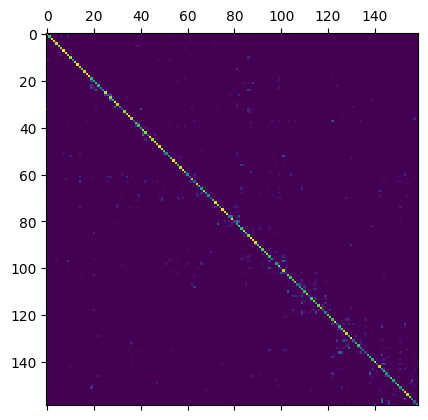

In [12]:
directory = f"{LONG_TRAINED_MODELS}mamba/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{directory}/weights_1_epochs.pt2"))
for epoch in (2, 3):
    print(f"Epoch {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=2000,
        evaluation_maximum_duration=60.0,
        patience_interval=2000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epochs.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

```
Epoch 1
 20%|██        | 2000/9938 [12:19<52:46,  2.51it/s] 
Halting evaluation after 35840 data points.
Halting evaluation after 37248 data points.
 20%|██        | 2002/9938 [15:31<89:16:55, 40.50s/it] 
Halting evaluation after 38592 data points.
1/1 F1: [0.85739, 0.59774, 0.5922, 0.49694]. Precision: [0.87484, 0.60462, 0.61093, 0.53951] 
Training loss: 4214.32890. Validation loss: 2545.63086. Patience: 200
 40%|████      | 4000/9938 [28:24<39:29,  2.51it/s]   
Halting evaluation after 35968 data points.
Halting evaluation after 37376 data points.
 40%|████      | 4002/9938 [31:35<66:33:37, 40.37s/it]
Halting evaluation after 37696 data points.
1/1 F1: [0.92348, 0.76443, 0.75945, 0.68304]. Precision: [0.9174, 0.77561, 0.76992, 0.7147] 
Training loss: 2014.28624. Validation loss: 1633.01114. Patience: 200
 60%|██████    | 6000/9938 [44:53<26:10,  2.51it/s]   
Halting evaluation after 35968 data points.
Halting evaluation after 36416 data points.
 60%|██████    | 6002/9938 [48:05<44:12:14, 40.43s/it]
Halting evaluation after 36352 data points.
1/1 F1: [0.96298, 0.87018, 0.85736, 0.78539]. Precision: [0.96811, 0.88827, 0.86672, 0.80866] 
Training loss: 1323.80200. Validation loss: 1104.82938. Patience: 200
 80%|████████  | 8000/9938 [1:01:17<12:50,  2.52it/s] 
Halting evaluation after 35968 data points.
Halting evaluation after 38336 data points.
 81%|████████  | 8002/9938 [1:04:28<21:43:32, 40.40s/it]
Halting evaluation after 39616 data points.
1/1 F1: [0.96567, 0.88643, 0.87648, 0.82104]. Precision: [0.96962, 0.91042, 0.88947, 0.84128] 
Training loss: 988.52070. Validation loss: 902.17800. Patience: 200
100%|██████████| 9938/9938 [1:17:10<00:00,  2.15it/s]   
Training loss: 988.52070. Validation loss: 902.17800. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [4214.328901916742, 2014.2862447053194, 1323.8020023331046, 988.52069600299]
Validation losses: [2545.6308627603066, 1633.0111430537318, 1104.829379501687, 902.1780008934619]
F1 scores: [array([0.85738644, 0.92348473, 0.96298407, 0.96566542]), array([0.59774023, 0.76442868, 0.87018375, 0.88643497]), array([0.59220187, 0.75944896, 0.85736297, 0.87647977]), array([0.49693591, 0.68304225, 0.78539114, 0.82104016])]
Precisions: [array([0.87483735, 0.91740414, 0.96810716, 0.96961679]), array([0.60461876, 0.77560659, 0.88826938, 0.91041909]), array([0.61092677, 0.76991842, 0.86671802, 0.88946738]), array([0.53951469, 0.71469979, 0.8086631 , 0.84128124])]

Epoch 2
 20%|██        | 2000/9938 [11:08<44:55,  2.94it/s]
Halting evaluation after 40256 data points.
Halting evaluation after 42880 data points.
 20%|██        | 2002/9938 [14:22<90:09:01, 40.89s/it] 
Halting evaluation after 44608 data points.
1/1 F1: [0.98025, 0.92803, 0.91897, 0.87699]. Precision: [0.97888, 0.92058, 0.91241, 0.88302] 
Training loss: 683.91071. Validation loss: 664.09522. Patience: 200
 40%|████      | 4000/9938 [26:28<37:40,  2.63it/s]   
Halting evaluation after 36096 data points.
Halting evaluation after 40000 data points.
 40%|████      | 4002/9938 [29:41<67:17:25, 40.81s/it]
Halting evaluation after 38976 data points.
1/1 F1: [0.98129, 0.94359, 0.93607, 0.89947]. Precision: [0.98278, 0.94295, 0.9346, 0.90565] 
Training loss: 604.61018. Validation loss: 549.66430. Patience: 200
 60%|██████    | 6000/9938 [42:30<25:25,  2.58it/s]   
Halting evaluation after 36800 data points.
Halting evaluation after 39488 data points.
 60%|██████    | 6002/9938 [45:42<44:22:05, 40.58s/it]
Halting evaluation after 39872 data points.
1/1 F1: [0.98782, 0.95791, 0.9448, 0.90794]. Precision: [0.98817, 0.95742, 0.94266, 0.90868] 
Training loss: 552.70418. Validation loss: 510.21007. Patience: 200
 80%|████████  | 8000/9938 [58:31<11:53,  2.71it/s]   
Halting evaluation after 36672 data points.
Halting evaluation after 40064 data points.
 81%|████████  | 8002/9938 [1:01:44<21:52:15, 40.67s/it]
Halting evaluation after 41024 data points.
1/1 F1: [0.98547, 0.95857, 0.95059, 0.9185]. Precision: [0.98241, 0.95587, 0.95229, 0.92467] 
Training loss: 506.67941. Validation loss: 438.80076. Patience: 200
100%|██████████| 9938/9938 [1:13:40<00:00,  2.25it/s]   
Training loss: 506.67941. Validation loss: 438.80076. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [683.9107073284686, 604.6101771108806, 552.7041794154793, 506.6794053995982]
Validation losses: [664.0952230675662, 549.6643038989581, 510.2100710520584, 438.80075681228163]
F1 scores: [array([0.98024964, 0.98128564, 0.98781685, 0.98546761]), array([0.9280308 , 0.94358759, 0.95790526, 0.95856657]), array([0.91897355, 0.93607221, 0.94479625, 0.95058923]), array([0.87699165, 0.89947097, 0.90793726, 0.91850418])]
Precisions: [array([0.97887557, 0.98278006, 0.98817162, 0.98240815]), array([0.92058103, 0.94295143, 0.95741658, 0.95587186]), array([0.91241024, 0.93460184, 0.94266202, 0.95229422]), array([0.88302165, 0.90565237, 0.90867854, 0.92467254])]

Epoch 3
 20%|██        | 2000/9938 [13:07<53:01,  2.50it/s] 
Halting evaluation after 35904 data points.
Halting evaluation after 36416 data points.
 20%|██        | 2002/9938 [16:18<88:59:41, 40.37s/it] 
Halting evaluation after 36032 data points.
1/1 F1: [0.98646, 0.96114, 0.95134, 0.92566]. Precision: [0.98974, 0.96185, 0.9561, 0.93274] 
Training loss: 409.63971. Validation loss: 388.43680. Patience: 200
 40%|████      | 4000/9938 [29:37<39:33,  2.50it/s]   
Halting evaluation after 35712 data points.
Halting evaluation after 38144 data points.
 40%|████      | 4002/9938 [32:48<66:40:12, 40.43s/it]
Halting evaluation after 37248 data points.
1/1 F1: [0.98734, 0.96779, 0.95599, 0.92875]. Precision: [0.99147, 0.96987, 0.959, 0.93551] 
Training loss: 402.99054. Validation loss: 364.69338. Patience: 200
 60%|██████    | 6000/9938 [45:48<26:13,  2.50it/s]   
Halting evaluation after 35968 data points.
Halting evaluation after 37824 data points.
 60%|██████    | 6002/9938 [49:00<44:13:54, 40.46s/it]
Halting evaluation after 39616 data points.
1/1 F1: [0.98838, 0.96648, 0.957, 0.93259]. Precision: [0.98414, 0.97162, 0.95876, 0.93716] 
Training loss: 382.02160. Validation loss: 350.77852. Patience: 200
 80%|████████  | 8000/9938 [1:01:47<12:09,  2.66it/s] 
Halting evaluation after 36416 data points.
Halting evaluation after 38592 data points.
 81%|████████  | 8002/9938 [1:04:59<21:47:45, 40.53s/it]
Halting evaluation after 38464 data points.
1/1 F1: [0.9939, 0.97392, 0.96535, 0.94024]. Precision: [0.99455, 0.97549, 0.96642, 0.94626] 
Training loss: 366.61260. Validation loss: 315.99948. Patience: 200
100%|██████████| 9938/9938 [1:17:40<00:00,  2.13it/s]   
Training loss: 366.61260. Validation loss: 315.99948. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [409.63971075229347, 402.9905437398702, 382.02159978915006, 366.612600480672]
Validation losses: [388.436803968084, 364.69338314857373, 350.77851847933545, 315.9994843513542]
F1 scores: [array([0.98645821, 0.98733708, 0.98838182, 0.99390342]), array([0.96113612, 0.96778681, 0.96648424, 0.97392343]), array([0.95133921, 0.95598687, 0.95700315, 0.96534897]), array([0.92565675, 0.92874529, 0.93258901, 0.94024337])]
Precisions: [array([0.98974105, 0.99146785, 0.98414224, 0.99454751]), array([0.96185235, 0.9698744 , 0.97162244, 0.97548595]), array([0.9561033 , 0.95899642, 0.95876292, 0.96642172]), array([0.93273911, 0.93551466, 0.93716238, 0.94626278])]
Training losses: [683.9107073284686, 604.6101771108806, 552.7041794154793, 506.6794053995982, 409.63971075229347, 402.9905437398702, 382.02159978915006, 366.612600480672]
Validation losses: [664.0952230675662, 549.6643038989581, 510.2100710520584, 438.80075681228163, 388.436803968084, 364.69338314857373, 350.77851847933545, 315.9994843513542]
F1 scores: [array([0.98024964, 0.98128564, 0.98781685, 0.98546761]), array([0.9280308 , 0.94358759, 0.95790526, 0.95856657]), array([0.91897355, 0.93607221, 0.94479625, 0.95058923]), array([0.87699165, 0.89947097, 0.90793726, 0.91850418]), array([0.98645821, 0.98733708, 0.98838182, 0.99390342]), array([0.96113612, 0.96778681, 0.96648424, 0.97392343]), array([0.95133921, 0.95598687, 0.95700315, 0.96534897]), array([0.92565675, 0.92874529, 0.93258901, 0.94024337])]
Precisions: [array([0.97887557, 0.98278006, 0.98817162, 0.98240815]), array([0.92058103, 0.94295143, 0.95741658, 0.95587186]), array([0.91241024, 0.93460184, 0.94266202, 0.95229422]), array([0.88302165, 0.90565237, 0.90867854, 0.92467254]), array([0.98974105, 0.99146785, 0.98414224, 0.99454751]), array([0.96185235, 0.9698744 , 0.97162244, 0.97548595]), array([0.9561033 , 0.95899642, 0.95876292, 0.96642172]), array([0.93273911, 0.93551466, 0.93716238, 0.94626278])]
```

100%|██████████| 2485/2485 [03:46<00:00, 10.98it/s]


F1 score: [np.float64(0.9311732685163379), np.float64(0.7703520941402231), np.float64(0.7660239548141485), np.float64(0.6683575466015613)]
Macro precision score: [np.float64(0.9012240565508962), np.float64(0.7886731246903617), np.float64(0.7762798767372944), np.float64(0.6924025007857574)]
Weighted precision score: [np.float64(0.9818070514090079), np.float64(0.8536650749777496), np.float64(0.8186976216017549), np.float64(0.6924025007857573)]


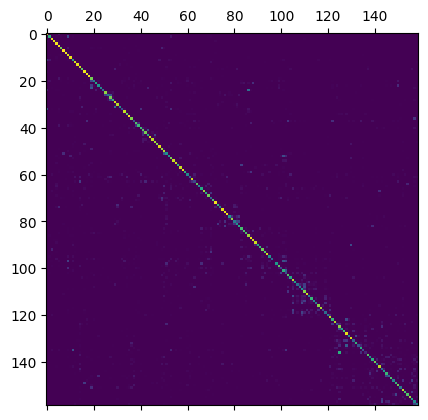

In [13]:
classifier.model.load_state_dict(load(f"{directory}/weights_2_epochs.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
# Epoch 1: 0.6369
# Epoch 2: 0.6924
# Epoch 3: 0.7066

#### 2.3.2.2. Mamba-Memory

In [10]:
directory = f"{LONG_TRAINED_MODELS}mamba_memory/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaMemorySequenceClassifier(
        N=None,
        num_classes=len(mapping),
        vocab_size=256,
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{directory}/weights_2_epochs.pt2"))
for epoch in (3, ):
    print(f"Epoch {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=2000,
        evaluation_maximum_duration=60.0,
        patience_interval=2000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epochs.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")

Epoch 3


 20%|██        | 2000/9938 [12:21<53:39,  2.47it/s]  

Halting evaluation after 35072 data points.
Halting evaluation after 36096 data points.


 20%|██        | 2002/9938 [15:32<89:10:05, 40.45s/it] 

Halting evaluation after 36224 data points.
1/1 F1: [0.99321, 0.97605, 0.96526, 0.94492]. Precision: [0.993, 0.97741, 0.96722, 0.94709] 
Training loss: 315.49423. Validation loss: 303.97229. Patience: 200


 40%|████      | 4000/9938 [8:42:36<32:13,  3.07it/s]        

Halting evaluation after 45184 data points.
Halting evaluation after 46656 data points.


 40%|████      | 4002/9938 [8:45:49<67:06:46, 40.70s/it]

Halting evaluation after 44928 data points.
1/1 F1: [0.9942, 0.97514, 0.96793, 0.9502]. Precision: [0.99403, 0.97549, 0.96642, 0.95194] 
Training loss: 313.13716. Validation loss: 271.79939. Patience: 200


 60%|██████    | 6000/9938 [8:57:16<26:37,  2.46it/s]   

Halting evaluation after 39488 data points.
Halting evaluation after 42112 data points.


 60%|██████    | 6002/9938 [9:00:28<44:23:14, 40.60s/it]

Halting evaluation after 42432 data points.
1/1 F1: [0.99341, 0.97858, 0.97073, 0.95156]. Precision: [0.9943, 0.98099, 0.97382, 0.95265] 
Training loss: 300.84392. Validation loss: 252.13600. Patience: 200


 80%|████████  | 8000/9938 [9:12:06<11:19,  2.85it/s]   

Halting evaluation after 38144 data points.
Halting evaluation after 42816 data points.


 81%|████████  | 8002/9938 [9:15:18<21:48:43, 40.56s/it]

Halting evaluation after 43456 data points.
1/1 F1: [0.9955, 0.98235, 0.97195, 0.95442]. Precision: [0.99671, 0.98261, 0.97381, 0.95719] 
Training loss: 293.39903. Validation loss: 237.61609. Patience: 200


100%|██████████| 9938/9938 [9:27:09<00:00,  3.42s/it]   


Training loss: 293.39903. Validation loss: 237.61609. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [315.49422702239826, 313.1371618201956, 300.8439205773175, 293.39902700297534]
Validation losses: [303.972292727669, 271.79939380218076, 252.13599699334458, 237.61609498896965]
F1 scores: [array([0.99321081, 0.99420419, 0.99340987, 0.99549878]), array([0.97605448, 0.9751405 , 0.97857586, 0.98234736]), array([0.96525887, 0.96793327, 0.97072672, 0.97194871]), array([0.94492197, 0.95019559, 0.95156163, 0.95441592])]
Precisions: [array([0.9929981 , 0.99403097, 0.99429576, 0.99670769]), array([0.97741216, 0.9754911 , 0.98098764, 0.98260582]), array([0.96722069, 0.96641548, 0.97382257, 0.97381031]), array([0.94708631, 0.95193638, 0.9526471 , 0.95719238])]
Training losses: [315.49422702239826, 313.1371618201956, 300.8439205773175, 293.39902700297534]
Validation losses: [303.972292727669, 271.79939380218076, 252.13599699334458, 237.61609498896965]
F1 scores: [a

```
Epoch 1
 20%|██        | 2000/9938 [11:13<52:01,  2.54it/s]
Halting evaluation after 36736 data points.
Halting evaluation after 37696 data points.
 20%|██        | 2002/9938 [14:25<89:21:48, 40.54s/it] 
Halting evaluation after 37440 data points.
1/1 F1: [0.91147, 0.74063, 0.73123, 0.6483]. Precision: [0.90268, 0.75358, 0.74313, 0.67412] 
Training loss: 3348.96774. Validation loss: 1789.33443. Patience: 200
 40%|████      | 4000/9938 [27:45<39:23,  2.51it/s]   
Halting evaluation after 34816 data points.
Halting evaluation after 36288 data points.
 40%|████      | 4002/9938 [30:56<66:33:56, 40.37s/it]
Halting evaluation after 36416 data points.
1/1 F1: [0.95696, 0.87066, 0.86295, 0.8005]. Precision: [0.97332, 0.87941, 0.86981, 0.81648] 
Training loss: 1386.47813. Validation loss: 1032.42902. Patience: 200
 60%|██████    | 6000/9938 [44:12<25:59,  2.53it/s]   
Halting evaluation after 35136 data points.
Halting evaluation after 36288 data points.
 60%|██████    | 6002/9938 [47:23<44:09:26, 40.39s/it]
Halting evaluation after 36032 data points.
1/1 F1: [0.97037, 0.90916, 0.90127, 0.84534]. Precision: [0.9554, 0.91086, 0.90292, 0.85777] 
Training loss: 925.97691. Validation loss: 826.88136. Patience: 200
 80%|████████  | 8000/9938 [1:00:43<13:06,  2.46it/s] 
Halting evaluation after 35136 data points.
Halting evaluation after 35456 data points.
 81%|████████  | 8002/9938 [1:03:54<21:44:03, 40.41s/it]
Halting evaluation after 36096 data points.
1/1 F1: [0.97173, 0.93191, 0.9215, 0.8817]. Precision: [0.96334, 0.93322, 0.91809, 0.88966] 
Training loss: 724.20812. Validation loss: 601.10425. Patience: 200
100%|██████████| 9938/9938 [1:16:50<00:00,  2.16it/s]   
Training loss: 724.20812. Validation loss: 601.10425. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [3348.9677410572767, 1386.4781303331256, 925.9769131578505, 724.2081230934709]
Validation losses: [1789.3344348821884, 1032.4290185538243, 826.8813575563381, 601.1042461354048]
F1 scores: [array([0.91147091, 0.95695706, 0.97036535, 0.97172664]), array([0.74062586, 0.87066219, 0.90916199, 0.93191102]), array([0.73122578, 0.86295054, 0.90127181, 0.92149693]), array([0.64829857, 0.80049728, 0.84534121, 0.88170125])]

Epoch 2
 20%|██        | 2000/9938 [12:09<47:18,  2.80it/s] 
Halting evaluation after 37824 data points.
Halting evaluation after 39360 data points.
 20%|██        | 2002/9938 [15:21<89:14:02, 40.48s/it] 
Halting evaluation after 42624 data points.
1/1 F1: [0.98616, 0.95433, 0.94204, 0.90993]. Precision: [0.98862, 0.95912, 0.94538, 0.9143] 
Training loss: 495.98162. Validation loss: 479.04930. Patience: 200
 40%|████      | 4000/9938 [28:09<39:18,  2.52it/s]   
Halting evaluation after 35136 data points.
Halting evaluation after 36992 data points.
 40%|████      | 4002/9938 [31:21<66:34:45, 40.38s/it]
Halting evaluation after 37760 data points.
1/1 F1: [0.98592, 0.95939, 0.94892, 0.92178]. Precision: [0.99037, 0.96212, 0.95222, 0.92882] 
Training loss: 454.23973. Validation loss: 410.64806. Patience: 200
 60%|██████    | 6000/9938 [44:25<26:40,  2.46it/s]   
Halting evaluation after 35072 data points.
Halting evaluation after 37632 data points.
 60%|██████    | 6002/9938 [47:38<44:38:37, 40.83s/it]
Halting evaluation after 38144 data points.
1/1 F1: [0.99136, 0.96798, 0.9597, 0.93426]. Precision: [0.99403, 0.96782, 0.96138, 0.93449] 
Training loss: 422.75205. Validation loss: 369.59345. Patience: 200
 80%|████████  | 8000/9938 [1:00:59<13:09,  2.45it/s] 
Halting evaluation after 35008 data points.
Halting evaluation after 36224 data points.
 81%|████████  | 8002/9938 [1:04:11<21:50:39, 40.62s/it]
Halting evaluation after 36480 data points.
1/1 F1: [0.98969, 0.96605, 0.958, 0.93422]. Precision: [0.99162, 0.96634, 0.96053, 0.93694] 
Training loss: 395.90407. Validation loss: 352.28595. Patience: 200
100%|██████████| 9938/9938 [1:17:17<00:00,  2.14it/s]   
Training loss: 395.90407. Validation loss: 352.28595. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [495.9816223885864, 454.2397335022688, 422.752048837021, 395.9040692243725]
Validation losses: [479.0493042820746, 410.64806086784705, 369.59345231220226, 352.28595473852596]
F1 scores: [array([0.98616273, 0.98591615, 0.99136013, 0.98968569]), array([0.95432648, 0.9593938 , 0.9679798 , 0.96605447]), array([0.94203741, 0.94891985, 0.95970264, 0.95799976]), array([0.90992529, 0.92178326, 0.93426144, 0.93421589])]
Precisions: [array([0.9886182 , 0.99036692, 0.99403224, 0.99162089]), array([0.95911807, 0.96211522, 0.96782079, 0.96633954]), array([0.94537677, 0.95222246, 0.96138347, 0.96052862]), array([0.91430039, 0.92882017, 0.93448502, 0.93694218])]

poch 3
 20%|██        | 2000/9938 [12:21<53:39,  2.47it/s]  
Halting evaluation after 35072 data points.
Halting evaluation after 36096 data points.
 20%|██        | 2002/9938 [15:32<89:10:05, 40.45s/it] 
Halting evaluation after 36224 data points.
1/1 F1: [0.99321, 0.97605, 0.96526, 0.94492]. Precision: [0.993, 0.97741, 0.96722, 0.94709] 
Training loss: 315.49423. Validation loss: 303.97229. Patience: 200
 40%|████      | 4000/9938 [8:42:36<32:13,  3.07it/s]        
Halting evaluation after 45184 data points.
Halting evaluation after 46656 data points.
 40%|████      | 4002/9938 [8:45:49<67:06:46, 40.70s/it]
Halting evaluation after 44928 data points.
1/1 F1: [0.9942, 0.97514, 0.96793, 0.9502]. Precision: [0.99403, 0.97549, 0.96642, 0.95194] 
Training loss: 313.13716. Validation loss: 271.79939. Patience: 200
 60%|██████    | 6000/9938 [8:57:16<26:37,  2.46it/s]   
Halting evaluation after 39488 data points.
Halting evaluation after 42112 data points.
 60%|██████    | 6002/9938 [9:00:28<44:23:14, 40.60s/it]
Halting evaluation after 42432 data points.
1/1 F1: [0.99341, 0.97858, 0.97073, 0.95156]. Precision: [0.9943, 0.98099, 0.97382, 0.95265] 
Training loss: 300.84392. Validation loss: 252.13600. Patience: 200
 80%|████████  | 8000/9938 [9:12:06<11:19,  2.85it/s]   
Halting evaluation after 38144 data points.
Halting evaluation after 42816 data points.
 81%|████████  | 8002/9938 [9:15:18<21:48:43, 40.56s/it]
Halting evaluation after 43456 data points.
1/1 F1: [0.9955, 0.98235, 0.97195, 0.95442]. Precision: [0.99671, 0.98261, 0.97381, 0.95719] 
Training loss: 293.39903. Validation loss: 237.61609. Patience: 200
100%|██████████| 9938/9938 [9:27:09<00:00,  3.42s/it]   
Training loss: 293.39903. Validation loss: 237.61609. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [315.49422702239826, 313.1371618201956, 300.8439205773175, 293.39902700297534]
Validation losses: [303.972292727669, 271.79939380218076, 252.13599699334458, 237.61609498896965]
F1 scores: [array([0.99321081, 0.99420419, 0.99340987, 0.99549878]), array([0.97605448, 0.9751405 , 0.97857586, 0.98234736]), array([0.96525887, 0.96793327, 0.97072672, 0.97194871]), array([0.94492197, 0.95019559, 0.95156163, 0.95441592])]
Precisions: [array([0.9929981 , 0.99403097, 0.99429576, 0.99670769]), array([0.97741216, 0.9754911 , 0.98098764, 0.98260582]), array([0.96722069, 0.96641548, 0.97382257, 0.97381031]), array([0.94708631, 0.95193638, 0.9526471 , 0.95719238])]
Training losses: [315.49422702239826, 313.1371618201956, 300.8439205773175, 293.39902700297534]
Validation losses: [303.972292727669, 271.79939380218076, 252.13599699334458, 237.61609498896965]
F1 scores: [array([0.99321081, 0.99420419, 0.99340987, 0.99549878]), array([0.97605448, 0.9751405 , 0.97857586, 0.98234736]), array([0.96525887, 0.96793327, 0.97072672, 0.97194871]), array([0.94492197, 0.95019559, 0.95156163, 0.95441592])]
Precisions: [array([0.9929981 , 0.99403097, 0.99429576, 0.99670769]), array([0.97741216, 0.9754911 , 0.98098764, 0.98260582]), array([0.96722069, 0.96641548, 0.97382257, 0.97381031]), array([0.94708631, 0.95193638, 0.9526471 , 0.95719238])]
```

100%|██████████| 2485/2485 [03:39<00:00, 11.34it/s]


F1 score: [np.float64(0.9541451730490129), np.float64(0.7909031240644996), np.float64(0.7867239559190944), np.float64(0.6888586314691058)]
Macro precision score: [np.float64(0.9394701588599708), np.float64(0.8149358181569146), np.float64(0.8004759318848476), np.float64(0.7041827010106194)]
Weighted precision score: [np.float64(0.9874052134253077), np.float64(0.865415307654233), np.float64(0.8303581241869537), np.float64(0.7041827010106193)]


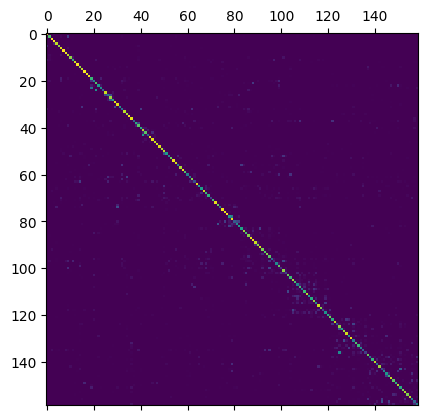

In [11]:
classifier.model.load_state_dict(load(f"{directory}/weights_3_epochs.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
# Epoch 1: 0.6494
# Epoch 2: 0.6924
# Epoch 3: 0.7041

#### 2.2.2.3. Mamba-CNN

In [ ]:
directory = f"{LONG_TRAINED_MODELS}mamba_cnn/"
mkdir(directory)
from torch import save
from stelaro.models import ssm

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    ssm.MambaSequenceClassifierCNN(
        N=None,
        num_classes=len(mapping),
        d_model=128,
        n_layers=4,
        d_state=16,
        d_conv=4,
        expand=2
    ),
    format.to_channels,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
classifier.model.load_state_dict(load(f"{directory}/weights_1_epochs.pt2"))
for epoch in (2, 3):
    print(f"Epoch {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=2000,
        evaluation_maximum_duration=60.0,
        patience_interval=2000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epochs.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

```
Epoch 1
 20%|██        | 2000/9938 [13:28<57:43,  2.29it/s]  
Halting evaluation after 31424 data points.
Halting evaluation after 32512 data points.
 20%|██        | 2002/9938 [16:39<88:52:19, 40.31s/it] 
Halting evaluation after 32640 data points.
1/1 F1: [0.94334, 0.82088, 0.80752, 0.71427]. Precision: [0.95175, 0.83609, 0.81129, 0.73812] 
Training loss: 3331.05919. Validation loss: 1524.34079. Patience: 200
 40%|████      | 4000/9938 [31:11<43:08,  2.29it/s]   
Halting evaluation after 31744 data points.
Halting evaluation after 31936 data points.
 40%|████      | 4002/9938 [34:21<66:13:55, 40.17s/it]
Halting evaluation after 31104 data points.
1/1 F1: [0.9758, 0.90591, 0.89398, 0.83945]. Precision: [0.97967, 0.91848, 0.90021, 0.85664] 
Training loss: 1186.65992. Validation loss: 913.14680. Patience: 200
 60%|██████    | 6000/9938 [49:04<28:54,  2.27it/s]   
Halting evaluation after 31424 data points.
Halting evaluation after 31872 data points.
 60%|██████    | 6002/9938 [52:15<43:59:21, 40.23s/it]
Halting evaluation after 30912 data points.
1/1 F1: [0.95562, 0.9259, 0.90858, 0.86487]. Precision: [0.93148, 0.92697, 0.91263, 0.88069] 
Training loss: 798.63272. Validation loss: 668.00133. Patience: 200
 80%|████████  | 8000/9938 [1:07:17<14:12,  2.27it/s] 
Halting evaluation after 28544 data points.
Halting evaluation after 31936 data points.
 81%|████████  | 8002/9938 [1:10:28<21:39:43, 40.28s/it]
Halting evaluation after 30976 data points.
1/1 F1: [0.98829, 0.94946, 0.9439, 0.90319]. Precision: [0.98587, 0.94784, 0.94423, 0.90933] 
Training loss: 639.60873. Validation loss: 548.55528. Patience: 200
100%|██████████| 9938/9938 [1:25:14<00:00,  1.94it/s]   
Training loss: 639.60873. Validation loss: 548.55528. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [3331.0591857880354, 1186.65992211923, 798.6327210143209, 639.6087273303419]
Validation losses: [1524.3407866534064, 913.1467977975622, 668.0013302551663, 548.5552828681986]
F1 scores: [array([0.94333504, 0.97580466, 0.95562086, 0.98829266]), array([0.82087885, 0.90591454, 0.92590483, 0.9494601 ]), array([0.8075162 , 0.89398496, 0.90857986, 0.94390446]), array([0.71427282, 0.83944811, 0.86486506, 0.90319315])]
Precisions: [array([0.95175153, 0.97966675, 0.93147719, 0.98587286]), array([0.83609275, 0.91848079, 0.92697268, 0.94784025]), array([0.81128725, 0.90020817, 0.91263365, 0.94423399]), array([0.73812161, 0.85664201, 0.8806947 , 0.90932562])]

Epoch 2
 20%|██        | 2000/9938 [11:45<47:19,  2.80it/s]
Halting evaluation after 39488 data points.
Halting evaluation after 39104 data points.
 20%|██        | 2002/9938 [14:57<89:09:53, 40.45s/it] 
Halting evaluation after 39104 data points.
1/1 F1: [0.98597, 0.95599, 0.94393, 0.90747]. Precision: [0.98663, 0.96052, 0.94802, 0.9139] 
Training loss: 493.91137. Validation loss: 455.29572. Patience: 200
 40%|████      | 4000/9938 [27:05<37:37,  2.63it/s]   
Halting evaluation after 35840 data points.
Halting evaluation after 39104 data points.
 40%|████      | 4002/9938 [30:16<66:33:34, 40.37s/it]
Halting evaluation after 39360 data points.
1/1 F1: [0.99233, 0.96319, 0.95326, 0.92227]. Precision: [0.99047, 0.95883, 0.95315, 0.93103] 
Training loss: 461.68850. Validation loss: 403.33398. Patience: 200
 60%|██████    | 6000/9938 [42:34<24:19,  2.70it/s]   
Halting evaluation after 35776 data points.
Halting evaluation after 37312 data points.
 60%|██████    | 6002/9938 [45:46<44:09:23, 40.39s/it]
Halting evaluation after 38080 data points.
1/1 F1: [0.99203, 0.96322, 0.95631, 0.92877]. Precision: [0.98927, 0.95747, 0.95599, 0.93276] 
Training loss: 431.30151. Validation loss: 372.95217. Patience: 200
 80%|████████  | 8000/9938 [58:16<11:52,  2.72it/s]   
Halting evaluation after 36800 data points.
Halting evaluation after 39680 data points.
 81%|████████  | 8002/9938 [1:01:28<21:44:09, 40.42s/it]
Halting evaluation after 39488 data points.
1/1 F1: [0.99489, 0.97583, 0.96681, 0.94235]. Precision: [0.99402, 0.97462, 0.96897, 0.94551] 
Training loss: 403.20342. Validation loss: 343.31503. Patience: 200
100%|██████████| 9938/9938 [1:13:30<00:00,  2.25it/s]   
Training loss: 403.20342. Validation loss: 343.31503. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [493.91136691812426, 461.6885030195117, 431.3015090441331, 403.2034194767475]
Validation losses: [455.29571535300505, 403.3339786820295, 372.95217014723966, 343.31502646171583]
F1 scores: [array([0.98596736, 0.99232733, 0.99202701, 0.99488904]), array([0.95598865, 0.96319202, 0.96321529, 0.97582917]), array([0.94392702, 0.95325677, 0.9563072 , 0.96680559]), array([0.90746648, 0.92226698, 0.92877347, 0.94234702])]
Precisions: [array([0.98662966, 0.99046965, 0.98927086, 0.99402468]), array([0.96051959, 0.95882701, 0.95746973, 0.97461542]), array([0.94801753, 0.95314919, 0.95598839, 0.96897064]), array([0.913902  , 0.93103078, 0.93276361, 0.94551381])]

Epoch 3
 20%|██        | 2000/9938 [13:44<56:35,  2.34it/s]  
Halting evaluation after 31936 data points.
Halting evaluation after 33728 data points.
 20%|██        | 2002/9938 [16:54<88:29:52, 40.15s/it] 
Halting evaluation after 32640 data points.
1/1 F1: [0.98442, 0.96678, 0.95592, 0.93276]. Precision: [0.97911, 0.96571, 0.95947, 0.93818] 
Training loss: 339.55103. Validation loss: 328.00514. Patience: 200
 40%|████      | 4000/9938 [31:03<40:24,  2.45it/s]   
Halting evaluation after 31808 data points.
Halting evaluation after 32896 data points.
 40%|████      | 4002/9938 [34:13<66:16:45, 40.20s/it]
Halting evaluation after 31808 data points.
1/1 F1: [0.99413, 0.97619, 0.96951, 0.94725]. Precision: [0.9941, 0.97435, 0.96992, 0.94983] 
Training loss: 328.65899. Validation loss: 272.52957. Patience: 200
 60%|██████    | 6000/9938 [48:35<28:16,  2.32it/s]   
Halting evaluation after 31680 data points.
Halting evaluation after 33408 data points.
 60%|██████    | 6002/9938 [51:46<44:01:16, 40.26s/it]
Halting evaluation after 32768 data points.
1/1 F1: [0.99434, 0.97575, 0.96891, 0.94367]. Precision: [0.99456, 0.97796, 0.971, 0.94652] 
Training loss: 320.12641. Validation loss: 280.46192. Patience: 199
 80%|████████  | 8000/9938 [1:06:07<13:20,  2.42it/s] 
Halting evaluation after 32064 data points.
Halting evaluation after 33664 data points.
 81%|████████  | 8002/9938 [1:09:18<21:40:24, 40.30s/it]
Halting evaluation after 36544 data points.
1/1 F1: [0.99511, 0.98035, 0.97269, 0.95333]. Precision: [0.99627, 0.98331, 0.97562, 0.95786] 
Training loss: 308.72940. Validation loss: 264.54382. Patience: 199
100%|██████████| 9938/9938 [1:22:37<00:00,  2.00it/s]   
Training loss: 308.72940. Validation loss: 264.54382. Patience: 199
Maximum number of epochs reached; stopping early.
Training losses: [339.55103398812935, 328.65899209678173, 320.1264118622057, 308.7294012797065]
Validation losses: [328.00514440545265, 272.529569625015, 280.46192431793315, 264.54382256364966]
F1 scores: [array([0.98441697, 0.99413131, 0.99433965, 0.99510944]), array([0.96677716, 0.97619267, 0.97574506, 0.98034782]), array([0.955919  , 0.96950758, 0.968906  , 0.97269369]), array([0.93275856, 0.9472464 , 0.94367116, 0.95332653])]
Precisions: [array([0.97910961, 0.99410484, 0.99455572, 0.9962699 ]), array([0.96570693, 0.97435072, 0.97796406, 0.98331314]), array([0.95947317, 0.9699221 , 0.97100047, 0.97561961]), array([0.93818145, 0.94983266, 0.94651736, 0.95785671])]
Training losses: [493.91136691812426, 461.6885030195117, 431.3015090441331, 403.2034194767475, 339.55103398812935, 328.65899209678173, 320.1264118622057, 308.7294012797065]
Validation losses: [455.29571535300505, 403.3339786820295, 372.95217014723966, 343.31502646171583, 328.00514440545265, 272.529569625015, 280.46192431793315, 264.54382256364966]
F1 scores: [array([0.98596736, 0.99232733, 0.99202701, 0.99488904]), array([0.95598865, 0.96319202, 0.96321529, 0.97582917]), array([0.94392702, 0.95325677, 0.9563072 , 0.96680559]), array([0.90746648, 0.92226698, 0.92877347, 0.94234702]), array([0.98441697, 0.99413131, 0.99433965, 0.99510944]), array([0.96677716, 0.97619267, 0.97574506, 0.98034782]), array([0.955919  , 0.96950758, 0.968906  , 0.97269369]), array([0.93275856, 0.9472464 , 0.94367116, 0.95332653])]
Precisions: [array([0.98662966, 0.99046965, 0.98927086, 0.99402468]), array([0.96051959, 0.95882701, 0.95746973, 0.97461542]), array([0.94801753, 0.95314919, 0.95598839, 0.96897064]), array([0.913902  , 0.93103078, 0.93276361, 0.94551381]), array([0.97910961, 0.99410484, 0.99455572, 0.9962699 ]), array([0.96570693, 0.97435072, 0.97796406, 0.98331314]), array([0.95947317, 0.9699221 , 0.97100047, 0.97561961]), array([0.93818145, 0.94983266, 0.94651736, 0.95785671])]
```

100%|██████████| 2485/2485 [03:51<00:00, 10.74it/s]


F1 score: [np.float64(0.9417313487171286), np.float64(0.7898954289982665), np.float64(0.7806110029320338), np.float64(0.6760296274040102)]
Macro precision score: [np.float64(0.9103955904719356), np.float64(0.824305725813697), np.float64(0.8081932346630738), np.float64(0.7077812353193503)]
Weighted precision score: [np.float64(0.9848266194662044), np.float64(0.8714567047326482), np.float64(0.8381996675705742), np.float64(0.7077812353193501)]


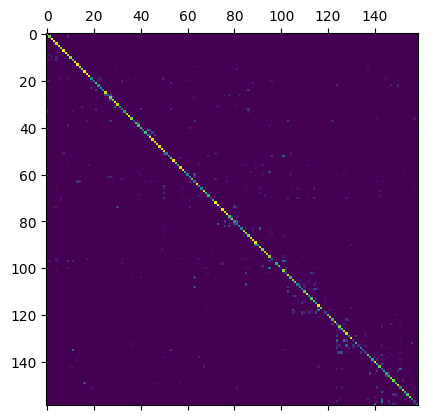

In [7]:
classifier.model.load_state_dict(load(f"{directory}/weights_2_epochs.pt2"))
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)
# epoch 1: 0.6663
# epoch 2: 0.7077
# epoch 3: 0.7340

#### 2.2.2.4. Mamba-Memory-CNN

#### 2.2.2.5. Transformer

Epoch 1


 20%|██        | 2000/9938 [31:06<2:07:48,  1.04it/s]

Halting evaluation after 15552 data points.
Halting evaluation after 16192 data points.


 20%|██        | 2001/9938 [34:13<124:56:39, 56.67s/it]

Halting evaluation after 13440 data points.
1/1 F1: [0.72988, 0.31496, 0.29916, 0.20819]. Precision: [0.73856, 0.31174, 0.32396, 0.24364] 
Training loss: 5280.86841. Validation loss: 4072.99100. Patience: 200


 40%|████      | 4000/9938 [1:06:04<1:34:04,  1.05it/s]

Halting evaluation after 16448 data points.
Halting evaluation after 16320 data points.


 40%|████      | 4001/9938 [1:09:12<93:39:04, 56.79s/it]

Halting evaluation after 13760 data points.
1/1 F1: [0.81586, 0.52998, 0.51767, 0.43752]. Precision: [0.83455, 0.55768, 0.55432, 0.47448] 
Training loss: 3350.13456. Validation loss: 2851.86101. Patience: 200


 60%|██████    | 6000/9938 [1:40:34<1:01:12,  1.07it/s] 

Halting evaluation after 17088 data points.
Halting evaluation after 17216 data points.


 60%|██████    | 6001/9938 [1:43:41<62:06:53, 56.80s/it]

Halting evaluation after 13760 data points.
1/1 F1: [0.86447, 0.63622, 0.63204, 0.55021]. Precision: [0.883, 0.68748, 0.67094, 0.58916] 
Training loss: 2499.98567. Validation loss: 2147.62748. Patience: 200


 80%|████████  | 8000/9938 [2:15:01<30:25,  1.06it/s]   

Halting evaluation after 16512 data points.
Halting evaluation after 16960 data points.


 81%|████████  | 8001/9938 [2:18:08<30:37:14, 56.91s/it]

Halting evaluation after 14080 data points.
1/1 F1: [0.90466, 0.70366, 0.6964, 0.61783]. Precision: [0.9023, 0.78084, 0.7445, 0.65887] 
Training loss: 2001.01329. Validation loss: 1824.27742. Patience: 200


100%|██████████| 9938/9938 [2:48:27<00:00,  1.02s/it]   


Training loss: 2001.01329. Validation loss: 1824.27742. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [5280.868409514427, 3350.13456004858, 2499.985672608018, 2001.0132859647274]
Validation losses: [4072.991001605988, 2851.861006437346, 2147.627476897351, 1824.2774174972014]
F1 scores: [array([0.72987906, 0.81585888, 0.86447103, 0.90465885]), array([0.31496293, 0.52998342, 0.63621872, 0.70366092]), array([0.29915639, 0.51766772, 0.63204211, 0.69639857]), array([0.20819121, 0.43752462, 0.55021011, 0.61782532])]
Precisions: [array([0.73856206, 0.8345525 , 0.88300432, 0.90229939]), array([0.31174034, 0.55767773, 0.68748017, 0.78083774]), array([0.32395515, 0.55432417, 0.67094165, 0.74449849]), array([0.24364142, 0.47448093, 0.58916145, 0.65886632])]
Epoch 2


 20%|██        | 2000/9938 [31:00<2:02:32,  1.08it/s]

Halting evaluation after 17024 data points.
Halting evaluation after 17216 data points.


 20%|██        | 2001/9938 [34:07<125:25:35, 56.89s/it]

Halting evaluation after 14336 data points.
1/1 F1: [0.91359, 0.77436, 0.76728, 0.69295]. Precision: [0.91483, 0.79245, 0.78471, 0.72333] 
Training loss: 1577.01425. Validation loss: 1479.42663. Patience: 200


 40%|████      | 4000/9938 [1:05:07<1:31:22,  1.08it/s]

Halting evaluation after 16576 data points.
Halting evaluation after 17152 data points.


 40%|████      | 4001/9938 [1:08:13<93:18:11, 56.58s/it]

Halting evaluation after 14208 data points.
1/1 F1: [0.93589, 0.81524, 0.80826, 0.7435]. Precision: [0.95125, 0.81894, 0.80989, 0.75986] 
Training loss: 1455.39012. Validation loss: 1321.23717. Patience: 200


 60%|██████    | 6000/9938 [1:39:21<1:00:24,  1.09it/s] 

Halting evaluation after 16768 data points.
Halting evaluation after 16576 data points.


 60%|██████    | 6001/9938 [1:42:27<61:53:38, 56.60s/it]

Halting evaluation after 14208 data points.
1/1 F1: [0.93808, 0.81085, 0.80373, 0.73598]. Precision: [0.93751, 0.81648, 0.80631, 0.74779] 
Training loss: 1359.40170. Validation loss: 1301.24039. Patience: 200


 80%|████████  | 8000/9938 [2:13:52<30:23,  1.06it/s]   

Halting evaluation after 16768 data points.
Halting evaluation after 16640 data points.


 81%|████████  | 8001/9938 [2:16:58<30:27:11, 56.60s/it]

Halting evaluation after 13760 data points.
1/1 F1: [0.94756, 0.80934, 0.81331, 0.74736]. Precision: [0.95341, 0.81782, 0.82702, 0.77319] 
Training loss: 1267.00785. Validation loss: 1245.88328. Patience: 200


100%|██████████| 9938/9938 [2:47:13<00:00,  1.01s/it]   


Training loss: 1267.00785. Validation loss: 1245.88328. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [1577.0142507255077, 1455.3901211097836, 1359.401704519987, 1267.0078473687172]
Validation losses: [1479.4266250516687, 1321.2371742403186, 1301.240385182806, 1245.8832848210666]
F1 scores: [array([0.91358568, 0.9358863 , 0.93807786, 0.9475594 ]), array([0.77435944, 0.81523644, 0.81084773, 0.8093377 ]), array([0.76727896, 0.80826378, 0.80372968, 0.81331375]), array([0.69294735, 0.74349835, 0.73597773, 0.74735748])]
Precisions: [array([0.91482611, 0.95124515, 0.93751028, 0.95341149]), array([0.79245121, 0.8189407 , 0.81647785, 0.81781777]), array([0.78471321, 0.8098905 , 0.80630934, 0.8270248 ]), array([0.72333105, 0.759861  , 0.74778868, 0.77318575])]
Epoch 3


 20%|██        | 2000/9938 [31:24<2:06:48,  1.04it/s]

Halting evaluation after 16448 data points.
Halting evaluation after 16768 data points.


 20%|██        | 2001/9938 [34:30<124:29:08, 56.46s/it]

Halting evaluation after 13824 data points.
1/1 F1: [0.95138, 0.84318, 0.8332, 0.76821]. Precision: [0.95525, 0.86528, 0.84778, 0.78846] 
Training loss: 1118.69964. Validation loss: 1117.67497. Patience: 200


 40%|████      | 4000/9938 [1:06:17<1:35:19,  1.04it/s]

Halting evaluation after 16384 data points.
Halting evaluation after 16192 data points.


 40%|████      | 4001/9938 [1:09:24<93:30:51, 56.70s/it]

Halting evaluation after 13504 data points.
1/1 F1: [0.95707, 0.86847, 0.85892, 0.79921]. Precision: [0.95797, 0.89866, 0.8874, 0.81867] 
Training loss: 1077.46591. Validation loss: 996.44191. Patience: 200


 60%|██████    | 6000/9938 [1:39:33<58:13,  1.13it/s]   

Halting evaluation after 17728 data points.
Halting evaluation after 18176 data points.


 60%|██████    | 6001/9938 [1:42:40<61:54:06, 56.60s/it]

Halting evaluation after 15040 data points.
1/1 F1: [0.95059, 0.84736, 0.84292, 0.78344]. Precision: [0.94318, 0.84532, 0.84786, 0.80607] 
Training loss: 1043.09203. Validation loss: 1010.96391. Patience: 199


 80%|████████  | 8000/9938 [2:12:10<28:37,  1.13it/s]   

Halting evaluation after 18048 data points.
Halting evaluation after 18240 data points.


 81%|████████  | 8001/9938 [2:15:17<30:26:30, 56.58s/it]

Halting evaluation after 15104 data points.
1/1 F1: [0.96875, 0.87634, 0.86882, 0.81103]. Precision: [0.95944, 0.87865, 0.87005, 0.82238] 
Training loss: 999.50348. Validation loss: 950.99532. Patience: 199


100%|██████████| 9938/9938 [2:43:53<00:00,  1.01it/s]   


Training loss: 999.50348. Validation loss: 950.99532. Patience: 199
Maximum number of epochs reached; stopping early.
Training losses: [1118.6996354609728, 1077.4659105688334, 1043.0920310541987, 999.50348225981]
Validation losses: [1117.6749701715178, 996.441910687781, 1010.9639078378677, 950.995315308288]
F1 scores: [array([0.95138299, 0.95706619, 0.95059182, 0.96874705]), array([0.84317662, 0.86847013, 0.84736014, 0.87634467]), array([0.83319661, 0.85891507, 0.84291995, 0.86882196]), array([0.76820934, 0.7992107 , 0.78344101, 0.81102887])]
Precisions: [array([0.95525347, 0.95797408, 0.94317698, 0.95944228]), array([0.86528374, 0.8986588 , 0.84531763, 0.87864507]), array([0.8477753 , 0.88739858, 0.84785929, 0.87004763]), array([0.78845724, 0.81866659, 0.80606548, 0.82237787])]
Training losses: [5280.868409514427, 3350.13456004858, 2499.985672608018, 2001.0132859647274, 1577.0142507255077, 1455.3901211097836, 1359.401704519987, 1267.0078473687172, 1118.6996354609728, 1077.465910568833

 57%|█████▋    | 1425/2485 [05:00<03:43,  4.75it/s]

Halting evaluation after 91264 data points.


F1 score: [np.float64(0.9028408389839087), np.float64(0.6637258528778354), np.float64(0.6472035160561107), np.float64(0.5341176726914101)]
Macro precision score: [np.float64(0.8959619334574702), np.float64(0.702727742113058), np.float64(0.6717753683889935), np.float64(0.5582279252431602)]
Weighted precision score: [np.float64(0.9727792765521148), np.float64(0.7543682199417818), np.float64(0.6936663931916875), np.float64(0.5587484383128781)]


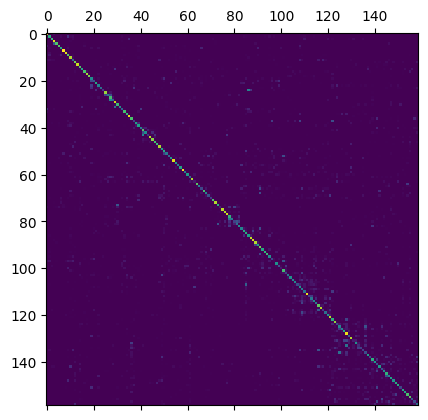

In [5]:
directory = f"{LONG_TRAINED_MODELS}transformer/"
mkdir(directory)
from torch import save, load
from stelaro.models import transformer

classifier = models.Classifier(
    READ_LENGTH // 4,
    mapping,
    "cuda",
    transformer.TransformerClassifier(
        N=READ_LENGTH // 4,
        num_classes=len(mapping),
        embed_dim=128,
        vocab_size=256,
        n_head=4,
        n_layers=4,
    ),
    format.to_tetramers,
    True
)
optimizer = Adam(classifier.get_parameters(), lr=0.001)
losses, validation_losses, f1, p = [], [], [], []
# classifier.model.load_state_dict(load(f"{directory}/weights_1_epochs.pt2"))
for epoch in (1, 2, 3):
    print(f"Epoch {epoch}")
    losses_, validation_losses_, f1_, p_ = classifier.train(
        train_data,
        validation_data,
        optimizer,
        max_n_epochs=1,
        patience=200,
        loss_function=nn.CrossEntropyLoss(),
        loss_function_type="supervised",
        evaluation_interval=2000,
        evaluation_maximum_duration=60.0,
        patience_interval=2000,
        n_max_steps=20_000
    )
    print(f"Training losses: {losses_}")
    print(f"Validation losses: {validation_losses_}")
    print(f"F1 scores: {f1_}")
    print(f"Precisions: {p_}")
    losses += losses_
    validation_losses += validation_losses_
    f1 += f1_
    p += p_
    save(classifier.model.state_dict(), f"{directory}weights_{epoch}_epochs.pt2")

print(f"Training losses: {losses}")
print(f"Validation losses: {validation_losses}")
print(f"F1 scores: {f1}")
print(f"Precisions: {p}")
models.benchmark_classifier(classifier, test_data, "cuda", mapping, 300)

```
Epoch 1
 20%|██        | 2000/9938 [31:06<2:07:48,  1.04it/s]
Halting evaluation after 15552 data points.
Halting evaluation after 16192 data points.
 20%|██        | 2001/9938 [34:13<124:56:39, 56.67s/it]
Halting evaluation after 13440 data points.
1/1 F1: [0.72988, 0.31496, 0.29916, 0.20819]. Precision: [0.73856, 0.31174, 0.32396, 0.24364] 
Training loss: 5280.86841. Validation loss: 4072.99100. Patience: 200
 40%|████      | 4000/9938 [1:06:04<1:34:04,  1.05it/s]
Halting evaluation after 16448 data points.
Halting evaluation after 16320 data points.
 40%|████      | 4001/9938 [1:09:12<93:39:04, 56.79s/it]
Halting evaluation after 13760 data points.
1/1 F1: [0.81586, 0.52998, 0.51767, 0.43752]. Precision: [0.83455, 0.55768, 0.55432, 0.47448] 
Training loss: 3350.13456. Validation loss: 2851.86101. Patience: 200
 60%|██████    | 6000/9938 [1:40:34<1:01:12,  1.07it/s] 
Halting evaluation after 17088 data points.
Halting evaluation after 17216 data points.
 60%|██████    | 6001/9938 [1:43:41<62:06:53, 56.80s/it]
Halting evaluation after 13760 data points.
1/1 F1: [0.86447, 0.63622, 0.63204, 0.55021]. Precision: [0.883, 0.68748, 0.67094, 0.58916] 
Training loss: 2499.98567. Validation loss: 2147.62748. Patience: 200
 80%|████████  | 8000/9938 [2:15:01<30:25,  1.06it/s]   
Halting evaluation after 16512 data points.
Halting evaluation after 16960 data points.
 81%|████████  | 8001/9938 [2:18:08<30:37:14, 56.91s/it]
Halting evaluation after 14080 data points.
1/1 F1: [0.90466, 0.70366, 0.6964, 0.61783]. Precision: [0.9023, 0.78084, 0.7445, 0.65887] 
Training loss: 2001.01329. Validation loss: 1824.27742. Patience: 200
100%|██████████| 9938/9938 [2:48:27<00:00,  1.02s/it]   
Training loss: 2001.01329. Validation loss: 1824.27742. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [5280.868409514427, 3350.13456004858, 2499.985672608018, 2001.0132859647274]
Validation losses: [4072.991001605988, 2851.861006437346, 2147.627476897351, 1824.2774174972014]
F1 scores: [array([0.72987906, 0.81585888, 0.86447103, 0.90465885]), array([0.31496293, 0.52998342, 0.63621872, 0.70366092]), array([0.29915639, 0.51766772, 0.63204211, 0.69639857]), array([0.20819121, 0.43752462, 0.55021011, 0.61782532])]
Precisions: [array([0.73856206, 0.8345525 , 0.88300432, 0.90229939]), array([0.31174034, 0.55767773, 0.68748017, 0.78083774]), array([0.32395515, 0.55432417, 0.67094165, 0.74449849]), array([0.24364142, 0.47448093, 0.58916145, 0.65886632])]

Epoch 2
 20%|██        | 2000/9938 [31:00<2:02:32,  1.08it/s]
Halting evaluation after 17024 data points.
Halting evaluation after 17216 data points.
 20%|██        | 2001/9938 [34:07<125:25:35, 56.89s/it]
Halting evaluation after 14336 data points.
1/1 F1: [0.91359, 0.77436, 0.76728, 0.69295]. Precision: [0.91483, 0.79245, 0.78471, 0.72333] 
Training loss: 1577.01425. Validation loss: 1479.42663. Patience: 200
 40%|████      | 4000/9938 [1:05:07<1:31:22,  1.08it/s]
Halting evaluation after 16576 data points.
Halting evaluation after 17152 data points.
 40%|████      | 4001/9938 [1:08:13<93:18:11, 56.58s/it]
Halting evaluation after 14208 data points.
1/1 F1: [0.93589, 0.81524, 0.80826, 0.7435]. Precision: [0.95125, 0.81894, 0.80989, 0.75986] 
Training loss: 1455.39012. Validation loss: 1321.23717. Patience: 200
 60%|██████    | 6000/9938 [1:39:21<1:00:24,  1.09it/s] 
Halting evaluation after 16768 data points.
Halting evaluation after 16576 data points.
 60%|██████    | 6001/9938 [1:42:27<61:53:38, 56.60s/it]
Halting evaluation after 14208 data points.
1/1 F1: [0.93808, 0.81085, 0.80373, 0.73598]. Precision: [0.93751, 0.81648, 0.80631, 0.74779] 
Training loss: 1359.40170. Validation loss: 1301.24039. Patience: 200
 80%|████████  | 8000/9938 [2:13:52<30:23,  1.06it/s]   
Halting evaluation after 16768 data points.
Halting evaluation after 16640 data points.
 81%|████████  | 8001/9938 [2:16:58<30:27:11, 56.60s/it]
Halting evaluation after 13760 data points.
1/1 F1: [0.94756, 0.80934, 0.81331, 0.74736]. Precision: [0.95341, 0.81782, 0.82702, 0.77319] 
Training loss: 1267.00785. Validation loss: 1245.88328. Patience: 200
100%|██████████| 9938/9938 [2:47:13<00:00,  1.01s/it]   
Training loss: 1267.00785. Validation loss: 1245.88328. Patience: 200
Maximum number of epochs reached; stopping early.
Training losses: [1577.0142507255077, 1455.3901211097836, 1359.401704519987, 1267.0078473687172]
Validation losses: [1479.4266250516687, 1321.2371742403186, 1301.240385182806, 1245.8832848210666]
F1 scores: [array([0.91358568, 0.9358863 , 0.93807786, 0.9475594 ]), array([0.77435944, 0.81523644, 0.81084773, 0.8093377 ]), array([0.76727896, 0.80826378, 0.80372968, 0.81331375]), array([0.69294735, 0.74349835, 0.73597773, 0.74735748])]
Precisions: [array([0.91482611, 0.95124515, 0.93751028, 0.95341149]), array([0.79245121, 0.8189407 , 0.81647785, 0.81781777]), array([0.78471321, 0.8098905 , 0.80630934, 0.8270248 ]), array([0.72333105, 0.759861  , 0.74778868, 0.77318575])]

Epoch 3
 20%|██        | 2000/9938 [31:24<2:06:48,  1.04it/s]
Halting evaluation after 16448 data points.
Halting evaluation after 16768 data points.
 20%|██        | 2001/9938 [34:30<124:29:08, 56.46s/it]
Halting evaluation after 13824 data points.
1/1 F1: [0.95138, 0.84318, 0.8332, 0.76821]. Precision: [0.95525, 0.86528, 0.84778, 0.78846] 
Training loss: 1118.69964. Validation loss: 1117.67497. Patience: 200
 40%|████      | 4000/9938 [1:06:17<1:35:19,  1.04it/s]
Halting evaluation after 16384 data points.
Halting evaluation after 16192 data points.
 40%|████      | 4001/9938 [1:09:24<93:30:51, 56.70s/it]
Halting evaluation after 13504 data points.
1/1 F1: [0.95707, 0.86847, 0.85892, 0.79921]. Precision: [0.95797, 0.89866, 0.8874, 0.81867] 
Training loss: 1077.46591. Validation loss: 996.44191. Patience: 200
 60%|██████    | 6000/9938 [1:39:33<58:13,  1.13it/s]   
Halting evaluation after 17728 data points.
Halting evaluation after 18176 data points.
 60%|██████    | 6001/9938 [1:42:40<61:54:06, 56.60s/it]
Halting evaluation after 15040 data points.
1/1 F1: [0.95059, 0.84736, 0.84292, 0.78344]. Precision: [0.94318, 0.84532, 0.84786, 0.80607] 
Training loss: 1043.09203. Validation loss: 1010.96391. Patience: 199
 80%|████████  | 8000/9938 [2:12:10<28:37,  1.13it/s]   
Halting evaluation after 18048 data points.
Halting evaluation after 18240 data points.
 81%|████████  | 8001/9938 [2:15:17<30:26:30, 56.58s/it]
Halting evaluation after 15104 data points.
1/1 F1: [0.96875, 0.87634, 0.86882, 0.81103]. Precision: [0.95944, 0.87865, 0.87005, 0.82238] 
Training loss: 999.50348. Validation loss: 950.99532. Patience: 199
100%|██████████| 9938/9938 [2:43:53<00:00,  1.01it/s]   
Training loss: 999.50348. Validation loss: 950.99532. Patience: 199
Maximum number of epochs reached; stopping early.
Training losses: [1118.6996354609728, 1077.4659105688334, 1043.0920310541987, 999.50348225981]
Validation losses: [1117.6749701715178, 996.441910687781, 1010.9639078378677, 950.995315308288]
F1 scores: [array([0.95138299, 0.95706619, 0.95059182, 0.96874705]), array([0.84317662, 0.86847013, 0.84736014, 0.87634467]), array([0.83319661, 0.85891507, 0.84291995, 0.86882196]), array([0.76820934, 0.7992107 , 0.78344101, 0.81102887])]
Precisions: [array([0.95525347, 0.95797408, 0.94317698, 0.95944228]), array([0.86528374, 0.8986588 , 0.84531763, 0.87864507]), array([0.8477753 , 0.88739858, 0.84785929, 0.87004763]), array([0.78845724, 0.81866659, 0.80606548, 0.82237787])]
Training losses: [5280.868409514427, 3350.13456004858, 2499.985672608018, 2001.0132859647274, 1577.0142507255077, 1455.3901211097836, 1359.401704519987, 1267.0078473687172, 1118.6996354609728, 1077.4659105688334, 1043.0920310541987, 999.50348225981]
Validation losses: [4072.991001605988, 2851.861006437346, 2147.627476897351, 1824.2774174972014, 1479.4266250516687, 1321.2371742403186, 1301.240385182806, 1245.8832848210666, 1117.6749701715178, 996.441910687781, 1010.9639078378677, 950.995315308288]
F1 scores: [array([0.72987906, 0.81585888, 0.86447103, 0.90465885]), array([0.31496293, 0.52998342, 0.63621872, 0.70366092]), array([0.29915639, 0.51766772, 0.63204211, 0.69639857]), array([0.20819121, 0.43752462, 0.55021011, 0.61782532]), array([0.91358568, 0.9358863 , 0.93807786, 0.9475594 ]), array([0.77435944, 0.81523644, 0.81084773, 0.8093377 ]), array([0.76727896, 0.80826378, 0.80372968, 0.81331375]), array([0.69294735, 0.74349835, 0.73597773, 0.74735748]), array([0.95138299, 0.95706619, 0.95059182, 0.96874705]), array([0.84317662, 0.86847013, 0.84736014, 0.87634467]), array([0.83319661, 0.85891507, 0.84291995, 0.86882196]), array([0.76820934, 0.7992107 , 0.78344101, 0.81102887])]
Precisions: [array([0.73856206, 0.8345525 , 0.88300432, 0.90229939]), array([0.31174034, 0.55767773, 0.68748017, 0.78083774]), array([0.32395515, 0.55432417, 0.67094165, 0.74449849]), array([0.24364142, 0.47448093, 0.58916145, 0.65886632]), array([0.91482611, 0.95124515, 0.93751028, 0.95341149]), array([0.79245121, 0.8189407 , 0.81647785, 0.81781777]), array([0.78471321, 0.8098905 , 0.80630934, 0.8270248 ]), array([0.72333105, 0.759861  , 0.74778868, 0.77318575]), array([0.95525347, 0.95797408, 0.94317698, 0.95944228]), array([0.86528374, 0.8986588 , 0.84531763, 0.87864507]), array([0.8477753 , 0.88739858, 0.84785929, 0.87004763]), array([0.78845724, 0.81866659, 0.80606548, 0.82237787])]
 57%|█████▋    | 1425/2485 [05:00<03:43,  4.75it/s]
```